In [ ]:
#Master Notebook

## **Loading In The Data**

In [ ]:
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD, RMSprop
import matplotlib.ticker as ticker
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import ttest_rel
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.decomposition import PCA

In [ ]:
# Initialise MAIN Dataset - insert file path here
dataset_path = 'insert file path here'

# Load dataset into a pandas DataFrame
df = pd.read_csv(dataset_path)

# Display the first few rows of the DataFrame to verify it's loaded correctly
df.head()

Date       Close   Volume Symbol Security  GICS Sector  \
0  30/9/2020  160.179993  3056900    MMM       3M  Industrials   
1  1/10/2020  158.789993  1989100    MMM       3M  Industrials   
2  2/10/2020  160.360001  1768600    MMM       3M  Industrials   
3  5/10/2020  162.750000  1457000    MMM       3M  Industrials   
4  6/10/2020  162.229996  2021900    MMM       3M  Industrials   

          GICS Sub-Industry  News - All News Volume  News - Volume  \
0  Industrial Conglomerates                     NaN            NaN   
1  Industrial Conglomerates                589369.0           47.0   
2  Industrial Conglomerates                506082.0           43.0   
3  Industrial Conglomerates                489872.0           50.0   
4  Industrial Conglomerates                550713.0           50.0   

   News - Positive Sentiment  ...  News - Analyst Comments  News - Stocks  \
0                        NaN  ...                      NaN            NaN   
1                        0.0  ...                      4.0            4.0   
2                        3.0  ...                      2.0            2.0   
3                        2.0  ...                      2.0            2.0   
4                        0.0  ...                      3.0            3.0   

   News - Dividends  News - Corporate Earnings  News - Mergers & Acquisitions  \
0               NaN                        NaN                            NaN   
1               0.0                        0.0                            0.0   
2               0.0                        2.0                            1.0   
3               0.0                        0.0                            2.0   
4               0.0                        0.0                            3.0   

   News - Store Openings  News - Product Recalls  News - Adverse Events  \
0                    NaN                     NaN                    NaN   
1                    0.0                     0.0                    0.0   
2                    0.0                     0.0                    1.0   
3                    0.0                     0.0                    0.0   
4                    0.0                     0.0                    3.0   

   News - Personnel Changes  News - Stock Rumors  
0                       NaN                  NaN  
1                       0.0                  0.0  
2                       0.0                  0.0  
3                       1.0                  0.0  
4                       0.0                  0.0  

[5 rows x 23 columns]

In [ ]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

# Add Log Close Column
df["Log_Close"] = np.log(df['Close'])

In [ ]:
print(df)

## **EXPLORATARY DATA ANALYSIS**

In the section we will explore different aspects of the dataset including summary statistics, rolling mean and standard deviation as well as index weight by sector

In [ ]:
# Function Created To Provide Summary Statistics
def information(df):

    df.info()

    date_diffs = df['Date'].diff().dt.days
    missing_dates = date_diffs[date_diffs > 1]

    if not missing_dates.empty:
        print("Missing Dates:")
        print(missing_dates)
    else:
        print("No missing dates based on consecutive day difference.")

    print("Uniques stocks available in dataset:", df['Security'].nunique())

    null_counts = df.isnull().sum()
    print("Null values in each column:")
    print(null_counts)

    stats= df.describe()
    print("Summary Statistics:")
    print(stats)


In [ ]:
df1 = df.copy()
information(df1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217811 entries, 0 to 217810
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Date                           217811 non-null  datetime64[ns]
 1   Close                          217811 non-null  float64       
 2   Volume                         217811 non-null  int64         
 3   Symbol                         217811 non-null  object        
 4   Security                       217811 non-null  object        
 5   GICS Sector                    217811 non-null  object        
 6   GICS Sub-Industry              217811 non-null  object        
 7   News - All News Volume         217318 non-null  float64       
 8   News - Volume                  217318 non-null  float64       
 9   News - Positive Sentiment      217318 non-null  float64       
 10  News - Negative Sentiment      217318 non-null  float64       
 11  

In [ ]:
df1['Market Cap'] = df1['Close'] * df1['Volume']

daily_sector_market_cap = df1.groupby(['Date', 'GICS Sector'])['Market Cap'].sum().reset_index()

avg_sector_market_cap = daily_sector_market_cap.groupby('GICS Sector')['Market Cap'].mean().sort_values(ascending=False)

top_sectors = avg_sector_market_cap.head(5).index

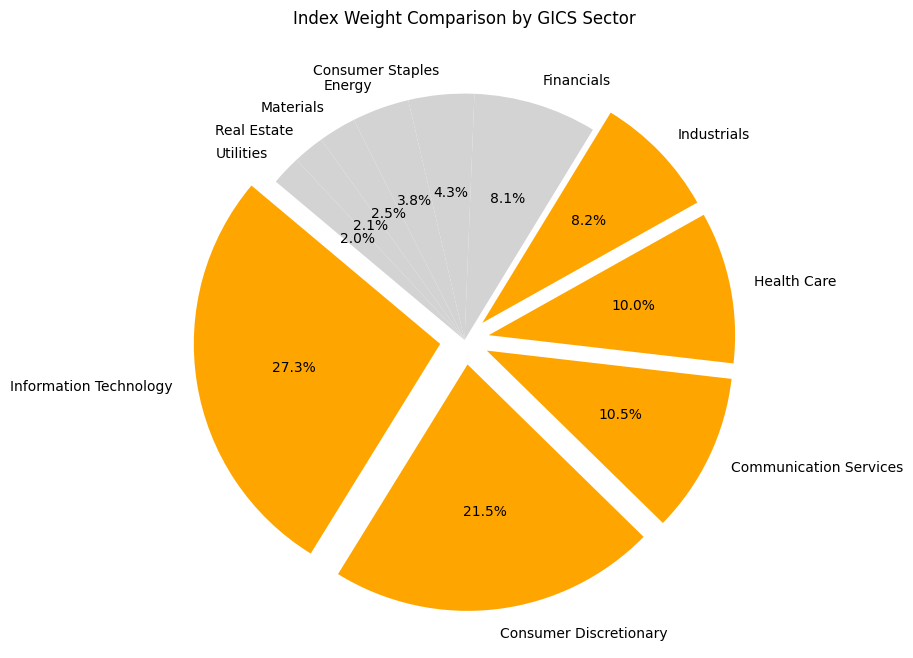

In [ ]:
colors = ['lightgrey' if (x not in top_sectors) else 'orange' for x in avg_sector_market_cap.index]
explode = [0.1 if (x in top_sectors) else 0 for x in avg_sector_market_cap.index]


plt.figure(figsize=(10, 8))
plt.pie(avg_sector_market_cap, labels=avg_sector_market_cap.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title('Index Weight Comparison by GICS Sector')
plt.show()

In [ ]:
# These are the top companies in each sector according to their index weight
top_company_by_sector = {}
for sector in top_sectors:
    companies_in_sector = df1[df1['GICS Sector'] == sector]
    top_company = companies_in_sector.groupby('Symbol')['Market Cap'].mean().idxmax()
    top_company_by_sector[sector] = top_company

top_company_by_sector

{'Information Technology': 'AAPL',
 'Consumer Discretionary': 'TSLA',
 'Communication Services': 'META',
 'Health Care': 'MRNA',
 'Industrials': 'BA'}

In this segment, we visualise the different time series plots including closing prices, rolling mean, and rolling standard deviation, which provide valuable information on how we should handle the models when we eventually train the data on it.

In [ ]:
apple_data = df1[df1['Symbol'] == 'AAPL']
tesla_data = df1[df1['Symbol'] == 'TSLA']
meta_data = df1[df1['Symbol'] == 'META']
moderna_data = df1[df1['Symbol'] == 'MRNA']
boeing_data = df1[df1['Symbol'] == 'BA']

apple_data.head()

Date       Close     Volume Symbol    Security  \
19845 2020-09-30  115.809998  142675200   AAPL  Apple Inc.   
19846 2020-10-01  116.790001  116120400   AAPL  Apple Inc.   
19847 2020-10-02  113.019997  144712000   AAPL  Apple Inc.   
19848 2020-10-05  116.500000  106243800   AAPL  Apple Inc.   
19849 2020-10-06  113.160004  161498200   AAPL  Apple Inc.   

                  GICS Sector                           GICS Sub-Industry  \
19845  Information Technology  Technology Hardware, Storage & Peripherals   
19846  Information Technology  Technology Hardware, Storage & Peripherals   
19847  Information Technology  Technology Hardware, Storage & Peripherals   
19848  Information Technology  Technology Hardware, Storage & Peripherals   
19849  Information Technology  Technology Hardware, Storage & Peripherals   

       News - All News Volume  News - Volume  News - Positive Sentiment  ...  \
19845                     NaN            NaN                        NaN  ...   
19846                589369.0         1178.0                      120.0  ...   
19847                506082.0         1285.0                      145.0  ...   
19848                489872.0         1315.0                      199.0  ...   
19849                550713.0         2287.0                      256.0  ...   

       News - Dividends  News - Corporate Earnings  \
19845               NaN                        NaN   
19846               0.0                        3.0   
19847               0.0                       11.0   
19848               1.0                        9.0   
19849               1.0                        5.0   

       News - Mergers & Acquisitions  News - Store Openings  \
19845                            NaN                    NaN   
19846                            4.0                    0.0   
19847                            5.0                    9.0   
19848                            2.0                    0.0   
19849                           11.0                   13.0   

       News - Product Recalls  News - Adverse Events  \
19845                     NaN                    NaN   
19846                     0.0                   19.0   
19847                     0.0                   14.0   
19848                    10.0                   99.0   
19849                     4.0                   51.0   

       News - Personnel Changes  News - Stock Rumors  Log_Close    Market Cap  
19845                       NaN                  NaN   4.751951  1.652321e+10  
19846                       0.0                  0.0   4.760377  1.356170e+10  
19847                       0.0                  0.0   4.727565  1.635535e+10  
19848                       1.0                  0.0   4.757891  1.237740e+10  
19849                       0.0                  0.0   4.728803  1.827514e+10  

[5 rows x 25 columns]

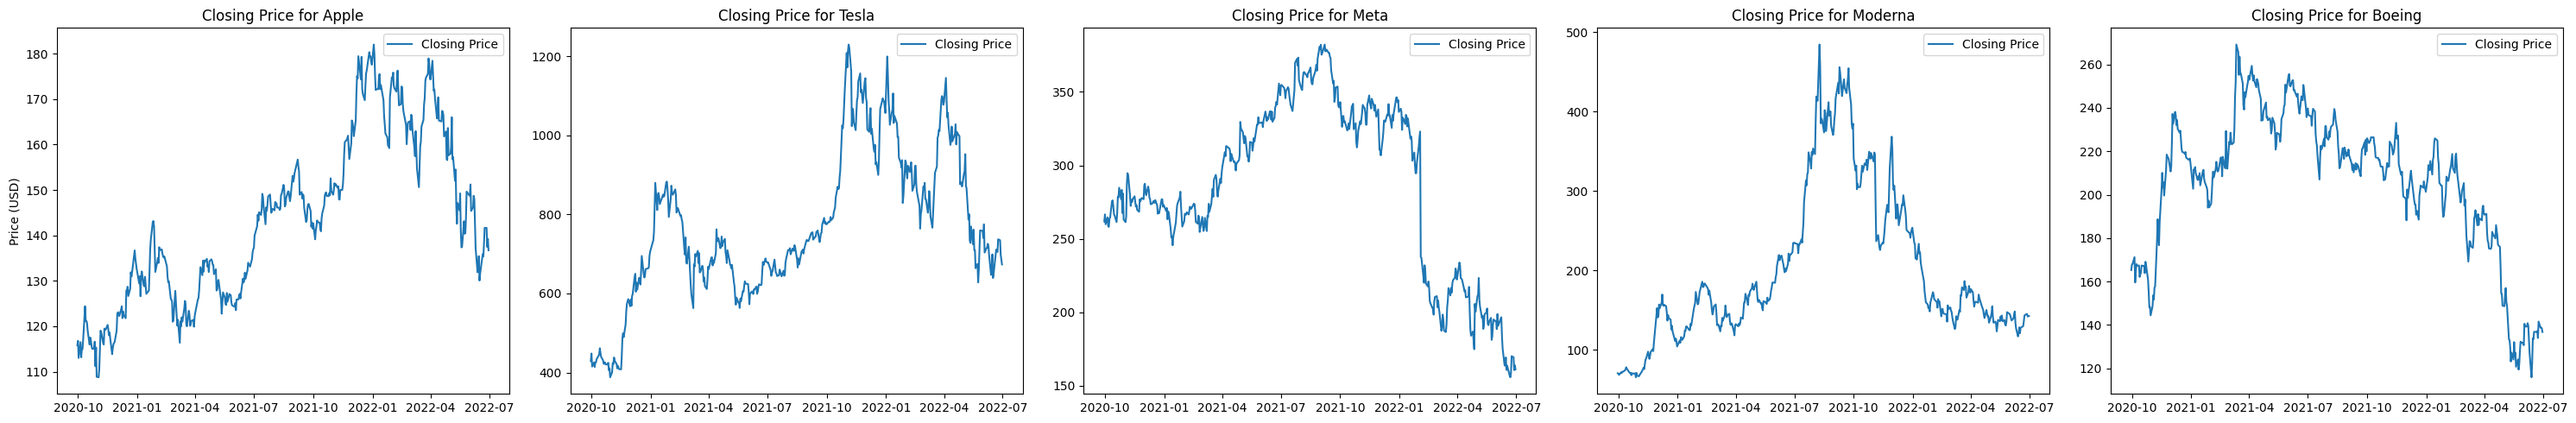

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(30,5), sharex='col')

axs[0].plot(apple_data['Date'], apple_data['Close'], label='Closing Price', color='tab:blue')
axs[0].set_title('Closing Price for Apple')
axs[0].set_ylabel('Price (USD)')
axs[0].legend()

axs[1].plot(tesla_data['Date'], tesla_data['Close'], label='Closing Price', color='tab:blue')
axs[1].set_title('Closing Price for Tesla')
axs[1].legend()

axs[2].plot(meta_data['Date'], meta_data['Close'], label='Closing Price', color='tab:blue')
axs[2].set_title('Closing Price for Meta')
axs[2].legend()

axs[3].plot(moderna_data['Date'], moderna_data['Close'], label='Closing Price', color='tab:blue')
axs[3].set_title('Closing Price for Moderna')
axs[3].legend()

axs[4].plot(boeing_data['Date'], boeing_data['Close'], label='Closing Price', color='tab:blue')
axs[4].set_title('Closing Price for Boeing')
axs[4].legend()

plt.tight_layout()
plt.show()

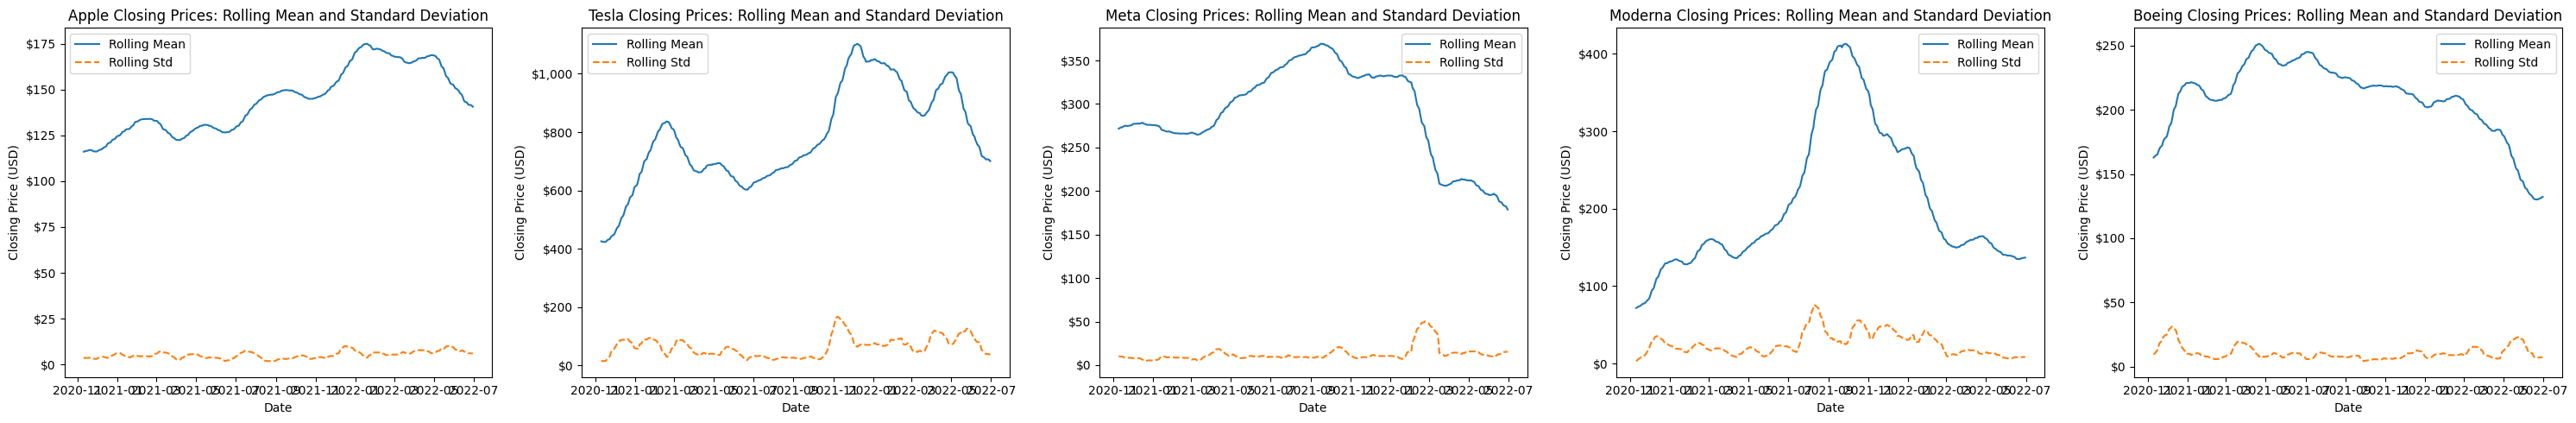

In [ ]:
fig, axs =plt.subplots(1, 5, figsize=(30,5), sharex='col')

window_size = 30

apple_rolling_mean = apple_data['Close'].rolling(window=window_size).mean()
apple_rolling_std = apple_data['Close'].rolling(window=window_size).std()


axs[0].plot(apple_data['Date'], apple_rolling_mean, label='Rolling Mean')
axs[0].plot(apple_data['Date'], apple_rolling_std, label='Rolling Std', linestyle='--')
axs[0].set_title('Apple Closing Prices: Rolling Mean and Standard Deviation')
axs[0].yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Closing Price (USD)')
axs[0].legend()


tesla_rolling_mean = tesla_data['Close'].rolling(window=window_size).mean()
tesla_rolling_std = tesla_data['Close'].rolling(window=window_size).std()

axs[1].plot(tesla_data['Date'], tesla_rolling_mean, label='Rolling Mean')
axs[1].plot(tesla_data['Date'], tesla_rolling_std, label='Rolling Std', linestyle='--')
axs[1].set_title('Tesla Closing Prices: Rolling Mean and Standard Deviation')
axs[1].yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Closing Price (USD)')
axs[1].legend()


meta_rolling_mean = meta_data['Close'].rolling(window=window_size).mean()
meta_rolling_std = meta_data['Close'].rolling(window=window_size).std()

axs[2].plot(meta_data['Date'], meta_rolling_mean, label='Rolling Mean')
axs[2].plot(meta_data['Date'], meta_rolling_std, label='Rolling Std', linestyle='--')
axs[2].set_title('Meta Closing Prices: Rolling Mean and Standard Deviation')
axs[2].yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Closing Price (USD)')
axs[2].legend()


moderna_rolling_mean = moderna_data['Close'].rolling(window=window_size).mean()
moderna_rolling_std = moderna_data['Close'].rolling(window=window_size).std()

axs[3].plot(moderna_data['Date'], moderna_rolling_mean, label='Rolling Mean')
axs[3].plot(moderna_data['Date'], moderna_rolling_std, label='Rolling Std', linestyle='--')
axs[3].set_title('Moderna Closing Prices: Rolling Mean and Standard Deviation')
axs[3].yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Closing Price (USD)')
axs[3].legend()


boeing_rolling_mean = boeing_data['Close'].rolling(window=window_size).mean()
boeing_rolling_std = boeing_data['Close'].rolling(window=window_size).std()

axs[4].plot(boeing_data['Date'], boeing_rolling_mean, label='Rolling Mean')
axs[4].plot(boeing_data['Date'], boeing_rolling_std, label='Rolling Std', linestyle='--')
axs[4].set_title('Boeing Closing Prices: Rolling Mean and Standard Deviation')
axs[4].yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
axs[4].set_xlabel('Date')
axs[4].set_ylabel('Closing Price (USD)')
axs[4].legend()
plt.tight_layout()
plt.show()

In this segment, we identify any securities that are outliers - not having the standard 441 trading days as the vast majority of securities have.

In [ ]:
# Group by the 'Security' column and count the number of rows for each unique security
security_counts = df1.groupby('Security').size()

# Print the sum of data rows for each unique security
print(security_counts)

# Calculate the average number of security counts
average_security_counts = security_counts.mean()

# Print the average number of security counts
print("Average number of security counts:", average_security_counts)

# Calculate the average number of security counts
average_security_counts = security_counts.mean()

# Find the mode of security counts
mode_security_counts = security_counts.mode()[0]

# Filter securities with counts different from the mode
different_counts_securities = security_counts[security_counts != mode_security_counts]

# Get the list of securities
securities_with_different_counts = different_counts_securities.index.tolist()

# Print the list of securities
print("Securities with counts different from the mode:")
print(securities_with_different_counts)


# Assuming you have a DataFrame called 'security_info' containing GICS Sector and GICS Sub-Industry information
# Replace 'security_info' with the actual name of your DataFrame

# Filter the DataFrame to include only the rows where the 'Security' column matches those listed in 'securities_with_different_counts'
securities_info_with_different_counts = df[df['Security'].isin(securities_with_different_counts)]

# Drop duplicate entries to retain only unique combinations of 'Security', 'GICS Sector', and 'GICS Sub-Industry'
unique_securities_info = securities_info_with_different_counts.drop_duplicates(subset=['Security', 'GICS Sector', 'GICS Sub-Industry'])

# Print the unique combinations of 'Security', 'GICS Sector', and 'GICS Sub-Industry' for securities with different counts
print("Unique combinations of 'Security', 'GICS Sector', and 'GICS Sub-Industry' for Securities with Different Counts:")
print(unique_securities_info[['Security', 'GICS Sector', 'GICS Sub-Industry']])


Security
3M                      441
A. O. Smith             441
ADM                     441
ADP                     441
AES Corporation         441
                       ... 
Zebra Technologies      441
Zimmer Biomet           441
Zions Bancorporation    441
Zoetis                  441
eBay                    441
Length: 495, dtype: int64
Average number of security counts: 440.02222222222224
Securities with counts different from the mode:
['Constellation Energy', 'Organon & Co.']
Unique combinations of 'Security', 'GICS Sector', and 'GICS Sub-Industry' for Securities with Different Counts:
                    Security  GICS Sector GICS Sub-Industry
54243   Constellation Energy    Utilities   Multi-Utilities
154463         Organon & Co.  Health Care   Pharmaceuticals


In [ ]:
securities_to_remove = ['Constellation Energy', 'Organon & Co.']

# Filter out rows corresponding to the securities to remove from original df
df = df[~df['Security'].isin(securities_to_remove)]

## **FEATURE SELECTION**

In this section, we aim to shortlist the most important features that affect closing prices using a variety of statistical tests and algorithms.

In [ ]:
small_constant = 1e-6

cat_var = ["Security", "GICS Sector", "GICS Sub-Industry", "Symbol"]

transformed_features = [
    'Log_Close','Log_Volume','Log_News - All News Volume','Log_News - Volume',
    'Log_News - Positive Sentiment',
    'Log_News - Negative Sentiment',
    'Log_News - New Products',
    'Log_News - Layoffs',
    'Log_News - Analyst Comments',
    'Log_News - Stocks',
    'Log_News - Dividends',
    'Log_News - Corporate Earnings',
    'Log_News - Mergers & Acquisitions',
    'Log_News - Store Openings',
    'Log_News - Product Recalls',
    'Log_News - Adverse Events',
    'Log_News - Personnel Changes',
    'Log_News - Stock Rumors']


top_5_sectors = ['Information Technology', 'Consumer Discretionary', 'Communication Services', 'Health Care', 'Industrials']


# Without Close as it is already log-transformed
original_features = ['Volume','News - All News Volume','News - Volume',
    'News - Positive Sentiment',
    'News - Negative Sentiment',
    'News - New Products',
    'News - Layoffs',
    'News - Analyst Comments',
    'News - Stocks',
    'News - Dividends',
    'News - Corporate Earnings',
    'News - Mergers & Acquisitions',
    'News - Store Openings',
    'News - Product Recalls',
    'News - Adverse Events',
    'News - Personnel Changes',
    'News - Stock Rumors']


In [ ]:
#HETEROSCEDASCITY

df_analysis = df.copy()
df_analysis.dropna(inplace=True)

X = df_analysis.drop(['Close', 'Date', 'Security', 'Symbol', 'GICS Sector', 'GICS Sub-Industry'], axis=1)
y = df_analysis['Close']

X = sm.add_constant(X)

model = OLS(y, X).fit()

residuals = model.resid

test_stat, p_value, _, _ = het_arch(residuals)

print(f"Test Statistic: {test_stat}")
print(f"P-Value: {p_value}")

Test Statistic: 216184.5757594495
P-Value: 0.0


The P-Value from the Heteroscedascity Test indicates to us that a transformation of the variables in our dataset are required. In this case, we went with a log - transformation.

In [ ]:
# Log Transform

for col in original_features:
    df_analysis[f'Log_{col}'] = np.log(df_analysis[col] + small_constant)

df_analysis.drop(original_features, axis=1, inplace=True)
# filter top 5 sectors
df_analysis = df_analysis[df_analysis['GICS Sector'].isin(top_5_sectors)]


<Axes: >

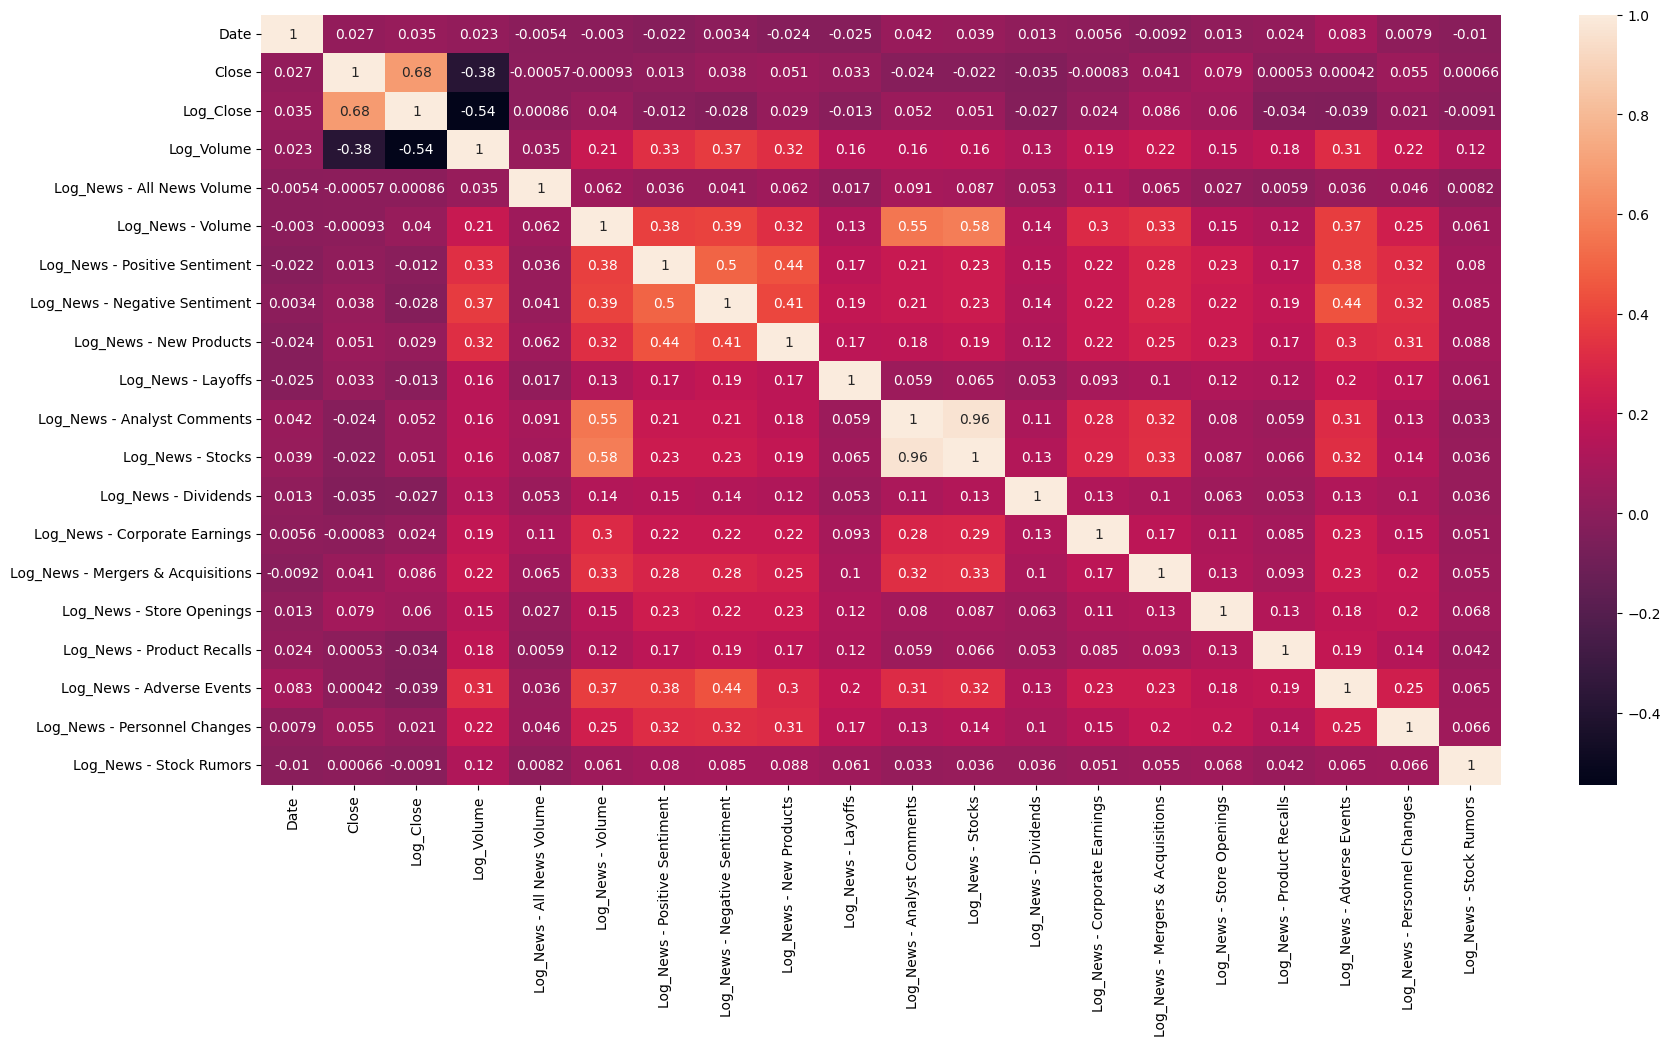

In [ ]:
#Calculating correlation between each pair of variables (Correlation Matrix)
matrix_df = df_analysis.drop(columns = cat_var)
corr_matrix = matrix_df.corr()

# Edit size of heatmap
plt.figure(1, figsize=(20,10))

# Creating a seaborn heatmap
sns.heatmap(corr_matrix, annot=True)

                                   importance
Log_Volume                           0.458747
Log_News - Volume                    0.188842
Log_News - All News Volume           0.087092
Log_News - Stocks                    0.038760
Log_News - Analyst Comments          0.037254
Log_News - Adverse Events            0.037219
Log_News - Positive Sentiment        0.031272
Log_News - Negative Sentiment        0.027710
Log_News - Corporate Earnings        0.026764
Log_News - Mergers & Acquisitions    0.022525
Log_News - New Products              0.018735
Log_News - Personnel Changes         0.010997
Log_News - Dividends                 0.007208
Log_News - Product Recalls           0.002601
Log_News - Store Openings            0.002372
Log_News - Layoffs                   0.001546
Log_News - Stock Rumors              0.000355


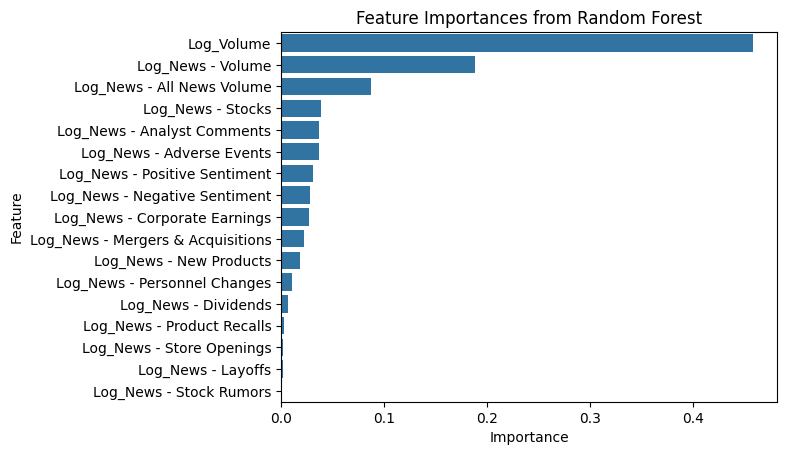

['Log_Volume',
 'Log_News - Volume',
 'Log_News - All News Volume',
 'Log_News - Stocks',
 'Log_News - Analyst Comments',
 'Log_News - Adverse Events',
 'Log_News - Positive Sentiment',
 'Log_News - Negative Sentiment',
 'Log_News - Corporate Earnings',
 'Log_News - Mergers & Acquisitions']

In [ ]:
#Random Forest
sp_500_numeric = df_analysis[transformed_features]

X = sp_500_numeric.drop('Log_Close', axis=1)
y = sp_500_numeric['Log_Close']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # Use RandomForestClassifier for classification tasks

# Fit the model
rf.fit(X_train, y_train)

importances = rf.feature_importances_

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)

sns.barplot(x='importance', y=feature_importances.index, data=feature_importances)

plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

cumulative_importances = np.cumsum(feature_importances.values.flatten())

n_important_features = np.where(cumulative_importances > 0.95)[0][0] + 1

# Extract the most important features
important_feature_names = feature_importances.index[:n_important_features].tolist()

important_feature_names

In [ ]:
#ANOVA
formula = 'Log_Close ~ Q("Log_Volume") + Q("Log_News - All News Volume") + Q("Log_News - Volume") + Q("Log_News - Positive Sentiment") + Q("Log_News - Negative Sentiment") + Q("Log_News - New Products") + Q("Log_News - Layoffs") + Q("Log_News - Analyst Comments") + Q("Log_News - Stocks") + Q("Log_News - Dividends") + Q("Log_News - Corporate Earnings") + Q("Log_News - Mergers & Acquisitions") + Q("Log_News - Store Openings") + Q("Log_News - Product Recalls") + Q("Log_News - Adverse Events") + Q("Log_News - Personnel Changes") + Q("Log_News - Stock Rumors")'

model = ols(formula, data=sp_500_numeric).fit()

anova_results = sm.stats.anova_lm(model, typ=2)

significant_features = anova_results[anova_results['PR(>F)']<0.05]

print(significant_features)

                                              sum_sq   df             F  \
Q("Log_Volume")                         44296.734504  1.0  80585.500154   
Q("Log_News - All News Volume")             9.111676  1.0     16.576142   
Q("Log_News - Volume")                      2.360053  1.0      4.293455   
Q("Log_News - Positive Sentiment")         73.768854  1.0    134.201766   
Q("Log_News - Negative Sentiment")        260.785115  1.0    474.425467   
Q("Log_News - New Products")             1197.955816  1.0   2179.345039   
Q("Log_News - Layoffs")                    35.268342  1.0     64.160868   
Q("Log_News - Analyst Comments")           25.334250  1.0     46.088572   
Q("Log_News - Corporate Earnings")        295.517494  1.0    537.611300   
Q("Log_News - Mergers & Acquisitions")   1723.720617  1.0   3135.826818   
Q("Log_News - Store Openings")            577.661085  1.0   1050.892532   
Q("Log_News - Product Recalls")            20.672991  1.0     37.608715   
Q("Log_News - Adverse Eve

In [ ]:
df_analysis.head()

Date       Close Symbol Security  GICS Sector  \
1 2020-10-01  158.789993    MMM       3M  Industrials   
2 2020-10-02  160.360001    MMM       3M  Industrials   
3 2020-10-05  162.750000    MMM       3M  Industrials   
4 2020-10-06  162.229996    MMM       3M  Industrials   
5 2020-10-07  166.490005    MMM       3M  Industrials   

          GICS Sub-Industry  Log_Close  Log_Volume  \
1  Industrial Conglomerates   5.067583   14.503193   
2  Industrial Conglomerates   5.077421   14.385699   
3  Industrial Conglomerates   5.092215   14.191890   
4  Industrial Conglomerates   5.089015   14.519548   
5  Industrial Conglomerates   5.114935   14.583487   

   Log_News - All News Volume  Log_News - Volume  ...  \
1                   13.286808           3.850148  ...   
2                   13.134454           3.761200  ...   
3                   13.101899           3.912023  ...   
4                   13.218969           3.912023  ...   
5                   13.259930           3.465736  ...   

   Log_News - Analyst Comments  Log_News - Stocks  Log_News - Dividends  \
1                     1.386295           1.386295            -13.815511   
2                     0.693148           0.693148            -13.815511   
3                     0.693148           0.693148            -13.815511   
4                     1.098613           1.098613            -13.815511   
5                     2.833213           2.833213            -13.815511   

   Log_News - Corporate Earnings  Log_News - Mergers & Acquisitions  \
1                     -13.815511                      -1.381551e+01   
2                       0.693148                       9.999995e-07   
3                     -13.815511                       6.931477e-01   
4                     -13.815511                       1.098613e+00   
5                     -13.815511                       9.999995e-07   

   Log_News - Store Openings  Log_News - Product Recalls  \
1                 -13.815511                  -13.815511   
2                 -13.815511                  -13.815511   
3                 -13.815511                  -13.815511   
4                 -13.815511                  -13.815511   
5                 -13.815511                  -13.815511   

   Log_News - Adverse Events  Log_News - Personnel Changes  \
1              -1.381551e+01                 -1.381551e+01   
2               9.999995e-07                 -1.381551e+01   
3              -1.381551e+01                  9.999995e-07   
4               1.098613e+00                 -1.381551e+01   
5              -1.381551e+01                 -1.381551e+01   

   Log_News - Stock Rumors  
1               -13.815511  
2               -13.815511  
3               -13.815511  
4               -13.815511  
5               -13.815511  

[5 rows x 24 columns]

Log_Volume: Variance: 0.2569
Log_News - All News Volume: Variance: 0.1040
Log_News - Volume: Variance: 0.0605
Log_News - Positive Sentiment: Variance: 0.0579
Log_News - Negative Sentiment: Variance: 0.0556
Log_News - New Products: Variance: 0.0543
Log_News - Layoffs: Variance: 0.0521
Log_News - Analyst Comments: Variance: 0.0515
Log_News - Stocks: Variance: 0.0485
Log_News - Dividends: Variance: 0.0452
Log_News - Corporate Earnings: Variance: 0.0445
Log_News - Mergers & Acquisitions: Variance: 0.0403
Log_News - Store Openings: Variance: 0.0390
Log_News - Product Recalls: Variance: 0.0324
Log_News - Adverse Events: Variance: 0.0288
Log_News - Personnel Changes: Variance: 0.0265
Log_News - Stock Rumors: Variance: 0.0020


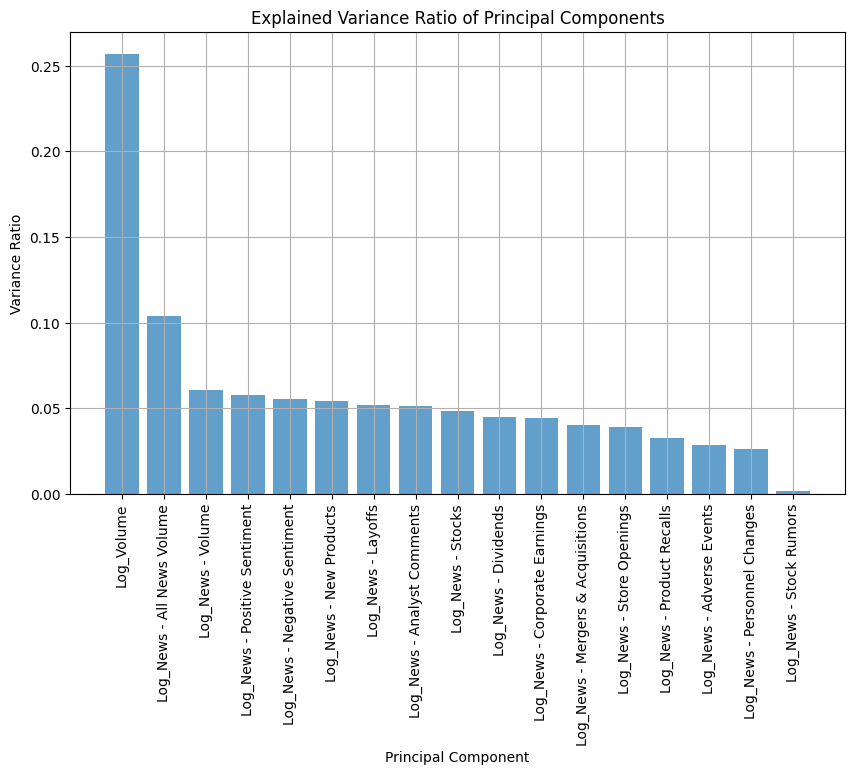

In [ ]:
#PCA
# Select numerical columns for PCA (excluding 'Close' and 'Market Cap')
X = sp_500_numeric.drop('Log_Close', axis=1)
y = sp_500_numeric['Log_Close']

column_names = list(X.columns)


# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_standardized)

# Get the names of the original numerical columns
column_names = list(X.columns)

# Extract explained variance ratios
variance_ratios = pca.explained_variance_ratio_

# Print the names of the components along with their variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
for i, var_ratio in enumerate(explained_variance_ratio):
    component_name = column_names[i]  # Use the column name as component name
    variance = f"Variance: {var_ratio:.4f}"
    print(f"{component_name}: {variance}")

# Plot the variances from PCs with principal component names
plt.figure(figsize=(10, 6))
plt.bar(column_names, variance_ratios, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()



In [ ]:
# Final Feature List

final_features = ['Date', 'Log_Close', 'Symbol', 'GICS Sector', 'Log_Volume', 'Log_News - All News Volume', 'Log_News - Volume','Log_News - Analyst Comments',
           'Log_News - Stocks', 'Log_News - Adverse Events']

## **Justification For Not Generalising Over Sectors for Arima**

In [ ]:
aggregations= {
    'Close': 'mean',  # or 'last' if you want the last closing price of the day
    'Volume': 'mean',
    'News - All News Volume': 'mean',
    'News - Volume': 'mean',
    'News - Positive Sentiment': 'mean',
    'News - Negative Sentiment': 'mean',
    'News - New Products': 'mean',
    'News - Layoffs': 'mean',
    'News - Analyst Comments': 'mean',
    'News - Stocks': 'mean',
    'News - Dividends': 'mean',
    'News - Corporate Earnings': 'mean',
    'News - Mergers & Acquisitions': 'mean',
    'News - Store Openings': 'mean',
    'News - Product Recalls': 'mean',
    'News - Adverse Events': 'mean',
    'News - Personnel Changes': 'mean',
    'News - Stock Rumors': 'mean'
}

# Aggregate data by GICS Sector and Date
sector_daily_agg = df.groupby(['Date', 'GICS Sector']).agg(aggregations).reset_index()


df_1 = df.copy()
df_1['Date'] = pd.to_datetime(df_1['Date'])
df_1.set_index('Date', inplace=True)

# Calculate daily returns
df_1['Daily Return'] = df_1.groupby(['GICS Sector', 'Symbol'])['Close'].pct_change()

sector = 'Information Technology'
Symbol = 'AAPL'

# Calculate rolling standard deviation (volatility) for the sector
sector_volatility = df_1[df_1['GICS Sector'] == sector].groupby('Date')['Daily Return'].mean().rolling(window=30).std()

# Calculate rolling standard deviation (volatility) for Apple
apple_volatility = df_1[(df_1['GICS Sector'] == sector) & (df_1['Symbol'] == Symbol)]['Daily Return'].rolling(window=30).std()

volatility_diff_test = ttest_rel(apple_volatility.dropna(), sector_volatility.loc[apple_volatility.dropna().index])

print(f"Paired T-Test results: Statistic={volatility_diff_test.statistic}, p-value={volatility_diff_test.pvalue}")

Paired T-Test results: Statistic=20.57307475055596, p-value=4.008264708543366e-65


The significant difference in variability (as indicated by the rolling standard deviation) between a single company and its entire sector suggests that a model fitted on data from one company (e.g., Apple) may not generalize well across the entire sector. This is because the underlying volatility and trends that the model captures for one company may not accurately reflect the broader movements within the sector.

## **THE ARIMA MODEL**

Stationary Test

In [ ]:
# This will be used for all models - dataset of relevant features and only top 5 sectors
final_df = df_analysis.copy()
final_df = final_df[final_features]

In [ ]:
print(len(final_df))
print(final_df.head())

128920
        Date  Log_Close Symbol  GICS Sector  Log_Volume  \
1 2020-10-01   5.067583    MMM  Industrials   14.503193   
2 2020-10-02   5.077421    MMM  Industrials   14.385699   
3 2020-10-05   5.092215    MMM  Industrials   14.191890   
4 2020-10-06   5.089015    MMM  Industrials   14.519548   
5 2020-10-07   5.114935    MMM  Industrials   14.583487   

   Log_News - All News Volume  Log_News - Volume  Log_News - Analyst Comments  \
1                   13.286808           3.850148                     1.386295   
2                   13.134454           3.761200                     0.693148   
3                   13.101899           3.912023                     0.693148   
4                   13.218969           3.912023                     1.098613   
5                   13.259930           3.465736                     2.833213   

   Log_News - Stocks  Log_News - Adverse Events  
1           1.386295              -1.381551e+01  
2           0.693148               9.999995e-07  
3

In [ ]:
apple_data = final_df[final_df['Symbol'] == 'AAPL']
tesla_data = final_df[final_df['Symbol'] == 'TSLA']
meta_data = final_df[final_df['Symbol'] == 'META']
moderna_data = final_df[final_df['Symbol'] == 'MRNA']
boeing_data = final_df[final_df['Symbol'] == 'BA']

This Section Contains ADF Test for the top 5 companies

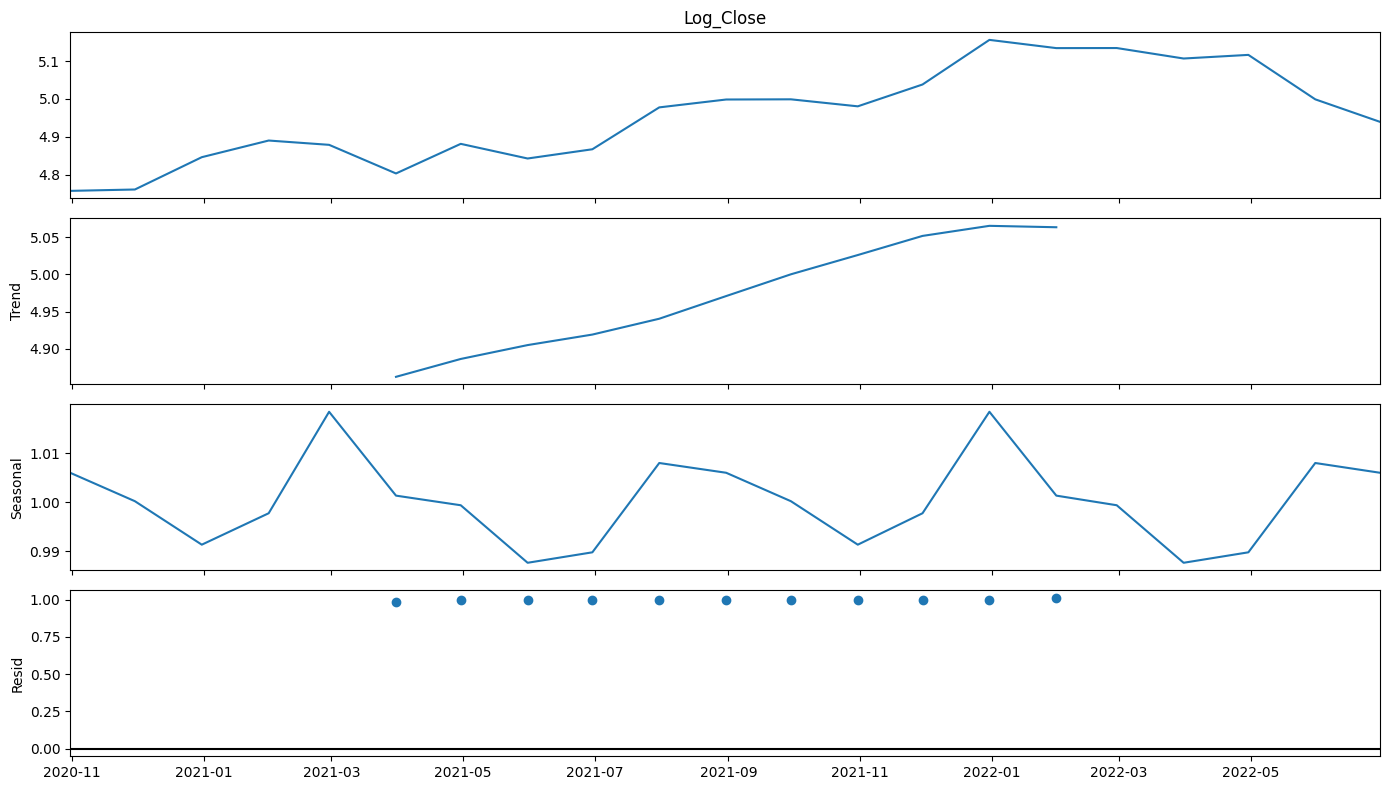

p-value: 0.3205274993803443
The time series is likely non-stationary.


In [ ]:
# Apple
apple_data_decomp = apple_data.copy()
apple_data_decomp.set_index('Date', inplace=True)

apple_data_decomp = apple_data_decomp['Log_Close'].resample('M').mean()

decomposition = seasonal_decompose(apple_data_decomp, model='multiplicative', period= 10)

fig = decomposition.plot()
fig.set_size_inches(14, 8)

plt.tight_layout()
plt.show()

adf_result = adfuller(apple_data['Log_Close'])
print('p-value:', adf_result[1])

if adf_result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")



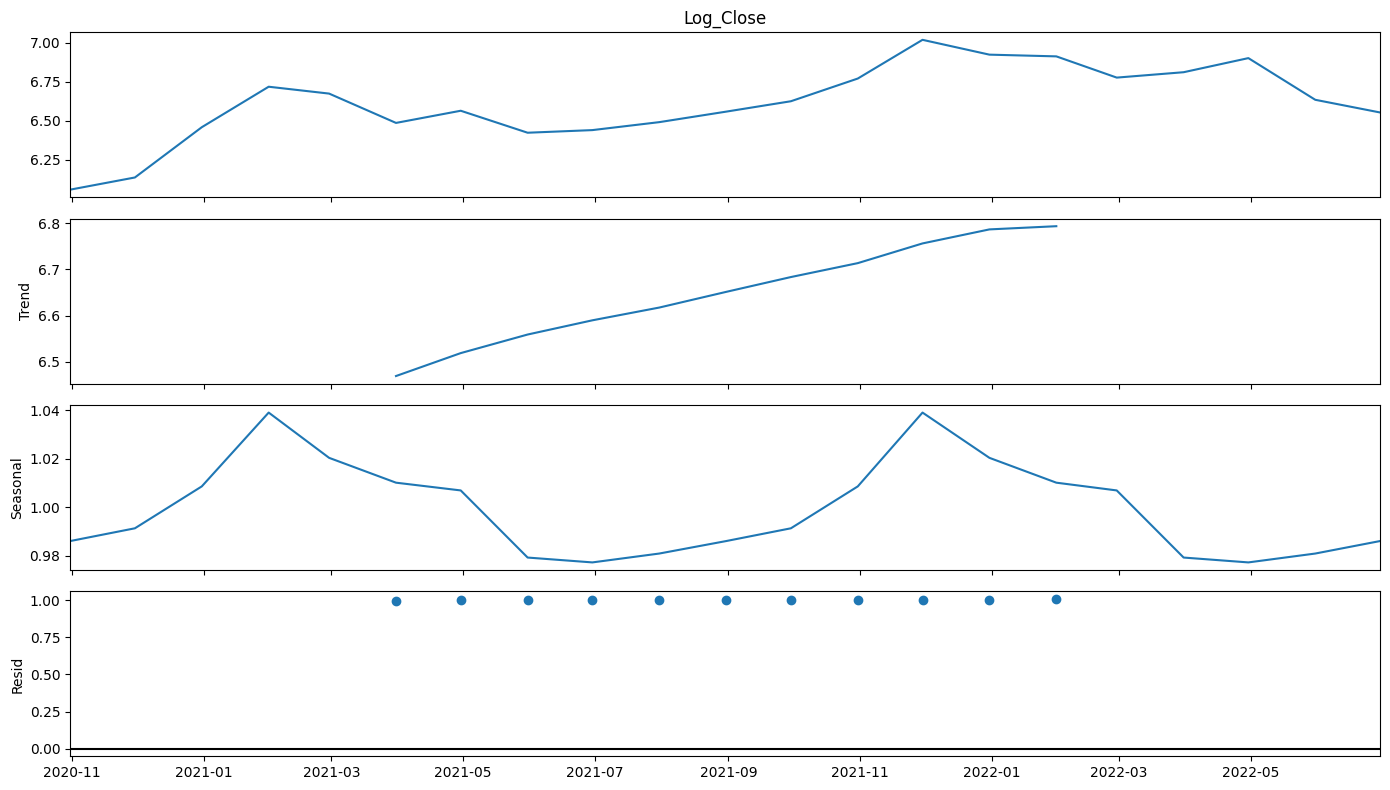

p-value: 0.20024616559736647
The time series is likely non-stationary.


In [ ]:
# Tesla
tesla_data_decomp = tesla_data.copy()
tesla_data_decomp.set_index('Date', inplace=True)

tesla_data_decomp = tesla_data_decomp['Log_Close'].resample('M').mean()

decomposition = seasonal_decompose(tesla_data_decomp, model='multiplicative', period= 10)

fig = decomposition.plot()
fig.set_size_inches(14, 8)

plt.tight_layout()
plt.show()

adf_result = adfuller(tesla_data['Log_Close'])
print('p-value:', adf_result[1])

if adf_result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

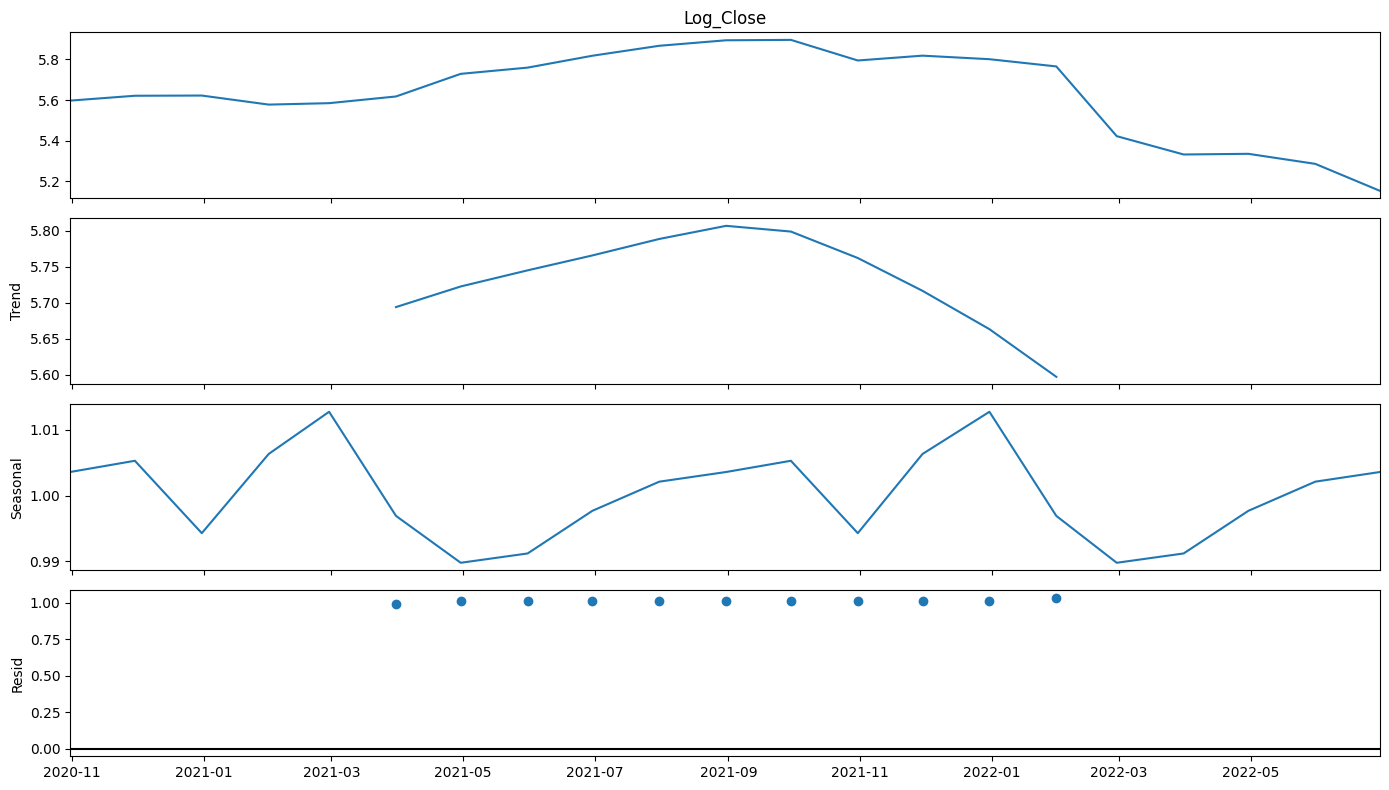

p-value: 0.9331328106346317
The time series is likely non-stationary.


In [ ]:
# Meta
meta_data_decomp = meta_data.copy()
meta_data_decomp.set_index('Date', inplace=True)

meta_data_decomp = meta_data_decomp['Log_Close'].resample('M').mean()

decomposition = seasonal_decompose(meta_data_decomp, model='multiplicative', period= 10)

fig = decomposition.plot()
fig.set_size_inches(14, 8)

plt.tight_layout()
plt.show()

adf_result = adfuller(meta_data['Log_Close'])
print('p-value:', adf_result[1])

if adf_result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")


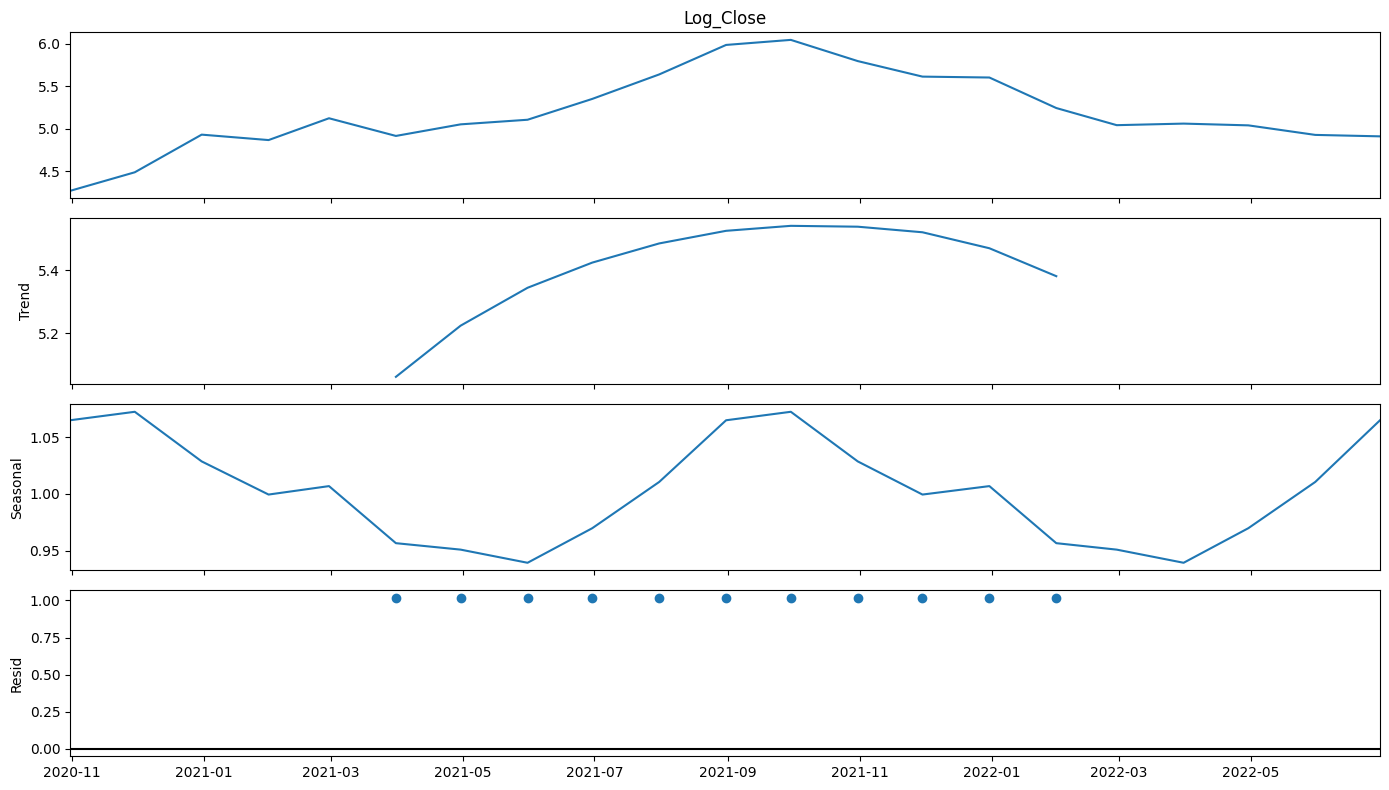

p-value: 0.23446969702522702
The time series is likely non-stationary.


In [ ]:
# Moderna

moderna_data_decomp = moderna_data.copy()
moderna_data_decomp.set_index('Date', inplace=True)

moderna_data_decomp = moderna_data_decomp['Log_Close'].resample('M').mean()

decomposition = seasonal_decompose(moderna_data_decomp, model='multiplicative', period= 10)

fig = decomposition.plot()
fig.set_size_inches(14, 8)

plt.tight_layout()
plt.show()

adf_result = adfuller(moderna_data['Log_Close'])
print('p-value:', adf_result[1])

if adf_result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

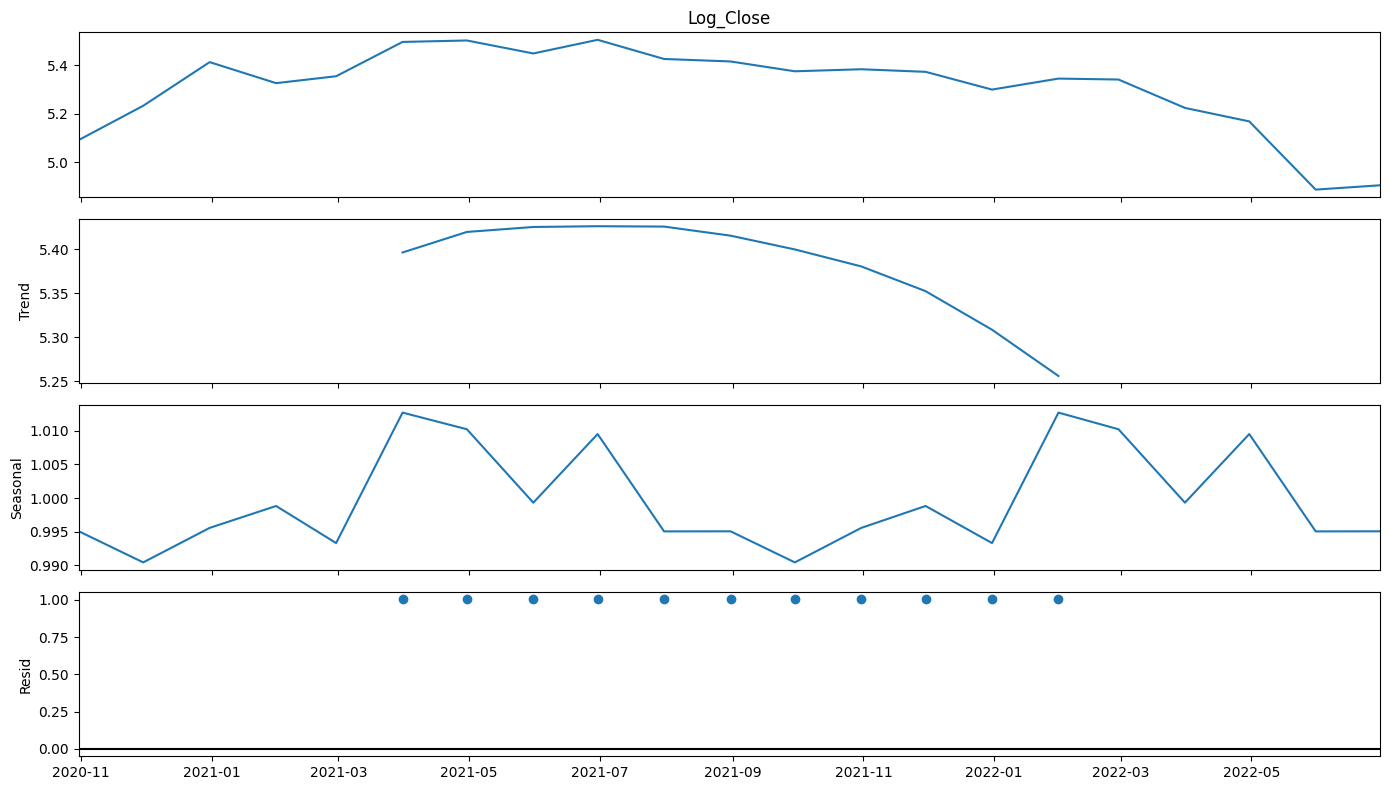

p-value: 0.7497649842730959
The time series is likely non-stationary.


In [ ]:
# Boeing
boeing_data_decomp = boeing_data.copy()
boeing_data_decomp.set_index('Date', inplace=True)

boeing_data_decomp = boeing_data_decomp['Log_Close'].resample('M').mean()

decomposition = seasonal_decompose(boeing_data_decomp, model='multiplicative', period= 10)

fig = decomposition.plot()
fig.set_size_inches(14, 8)

plt.tight_layout()
plt.show()

adf_result = adfuller(boeing_data['Log_Close'].dropna())
print('p-value:', adf_result[1])

if adf_result[1] > 0.05:
    print("The time series is likely non-stationary.")
else:
    print("The time series is likely stationary.")

This segment prepares the dataset for the ARIMA Model, including scaling each security.

In [ ]:
arima_df = final_df.copy()

scaled_dfs = []
scaler = StandardScaler()

# Iterate over each security
for security_name, security_data in final_df.groupby('Symbol'):
    # Select only the numeric columns for scaling
    numeric_cols = security_data.select_dtypes(include=[np.number]).columns

    # Standardize the numeric columns
    scaled_data = scaler.fit_transform(security_data[numeric_cols])

    # Create a DataFrame with the scaled data
    scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols, index=security_data.index)

    # Combine the scaled DataFrame with non-numeric columns
    scaled_df = pd.concat([scaled_df, security_data.drop(columns=numeric_cols)], axis=1)

    # Convert 'Date' column to datetime format and set it as index
    #scaled_df['Date'] = pd.to_datetime(scaled_df['Date'])
    #scaled_df.set_index('Date', inplace=True)

    # Add the standardized DataFrame to the list
    scaled_dfs.append(scaled_df)

# Concatenate the scaled DataFrames for all securities
arima_df = pd.concat(scaled_dfs)

# Ensure the index is not duplicated
arima_df.reset_index(drop=True, inplace=True)

In [ ]:
def reverse_transform(main_df, security, target):
    filter_df = main_df[main_df['Symbol'] == security]['Log_Close']
    mean = filter_df.mean()
    std = filter_df.std()
    target = (target * std) + mean
    target = np.exp(target)
    return target

This Segment contains the training over the SARIMAX model, looped over the topn 5 securities as previously mentioned.

Training Over Security: AAPL
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=442.804, Time=0.16 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-283.539, Time=2.81 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=96.316, Time=2.37 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=453.443, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-180.902, Time=0.37 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-325.614, Time=5.40 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=8.21 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=426.512, Time=1.63 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-323.834, Time=5.41 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-323.857, Time=7.60 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=97.163, Time=5.32 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-322.501, Time=13.60 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=-326.585, Time=1.37 sec
 ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


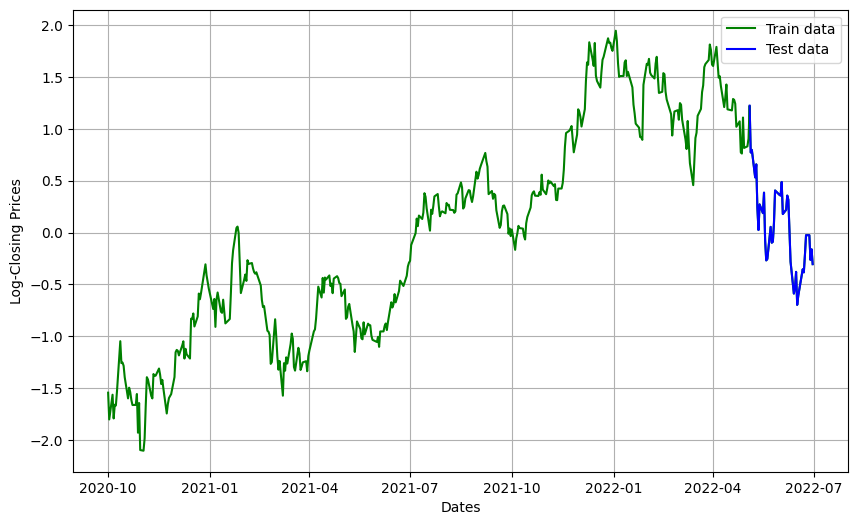

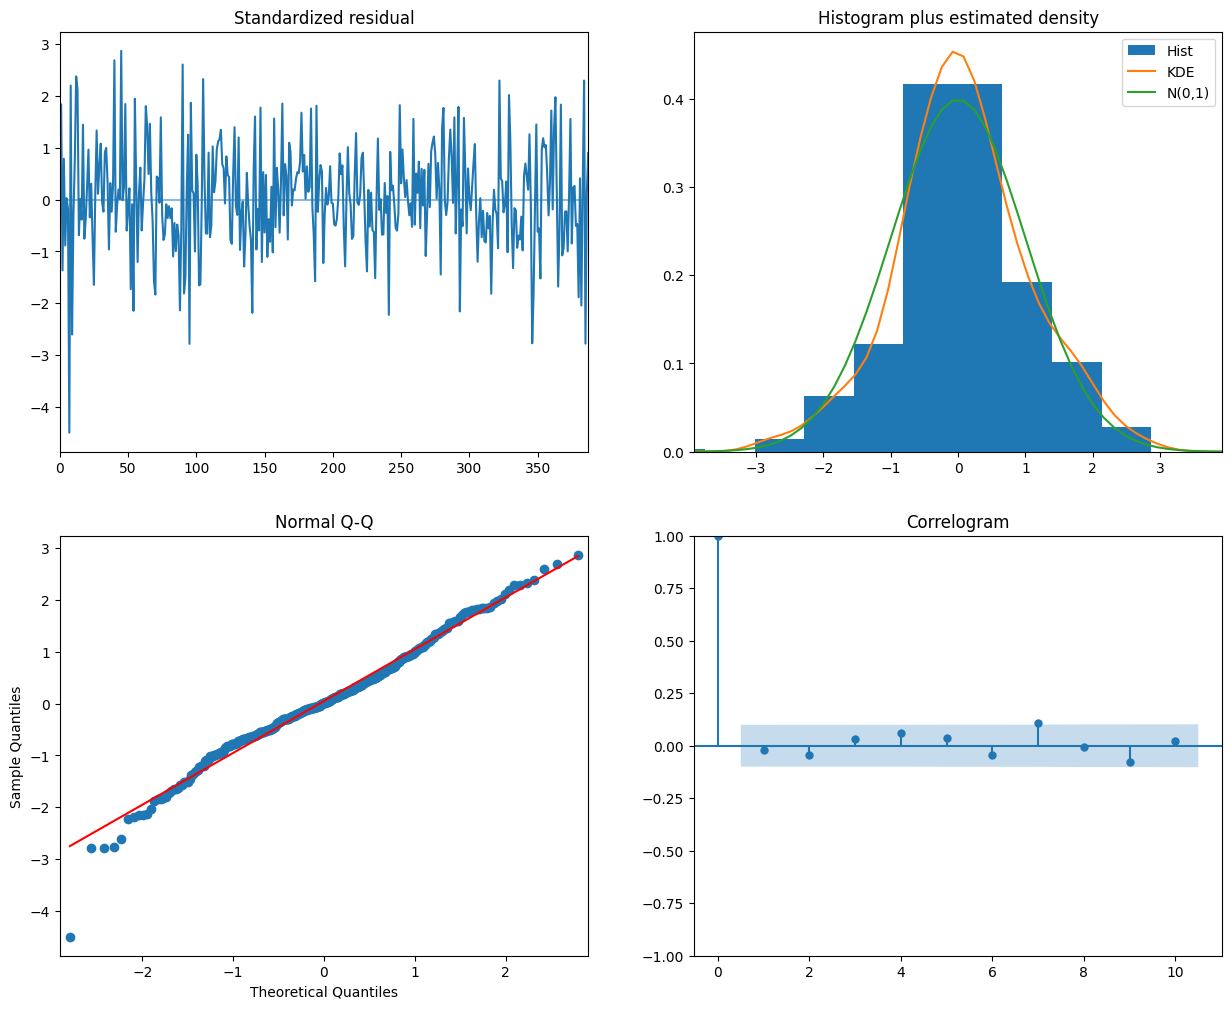

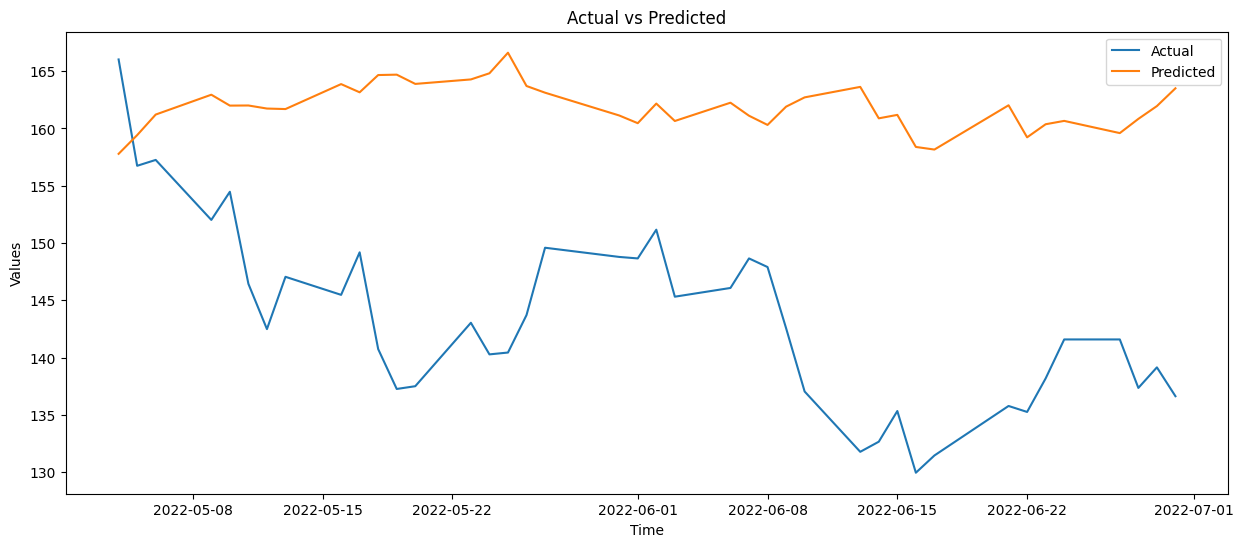

MSE: 411.0513567276506
RMSE: 20.27440151342699
MAE: 18.95498894841337
MAPE: 0.1351334995163001
Training Over Security: TSLA
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=586.984, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-286.685, Time=1.38 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=230.480, Time=2.02 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=598.113, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-162.354, Time=0.20 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-299.444, Time=4.29 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=13.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.57 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=590.822, Time=1.44 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-297.641, Time=5.11 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-297.633, Time=5.86 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=232.322, Time=4.82 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


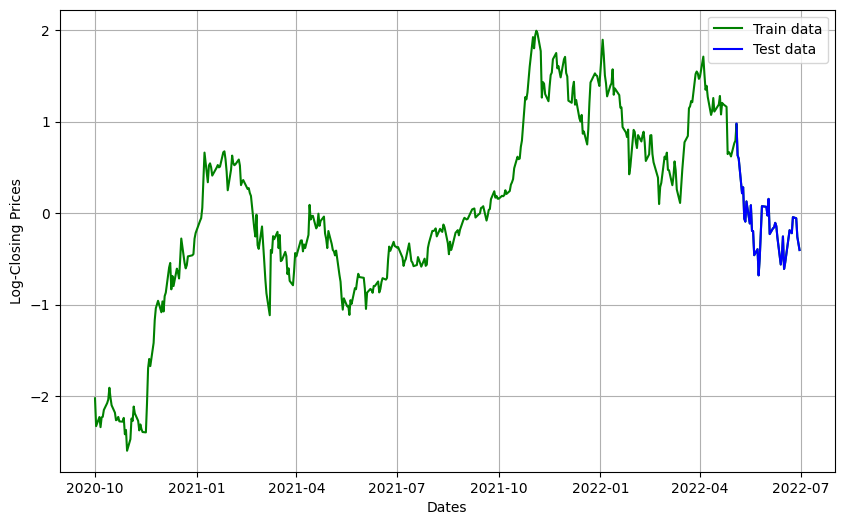

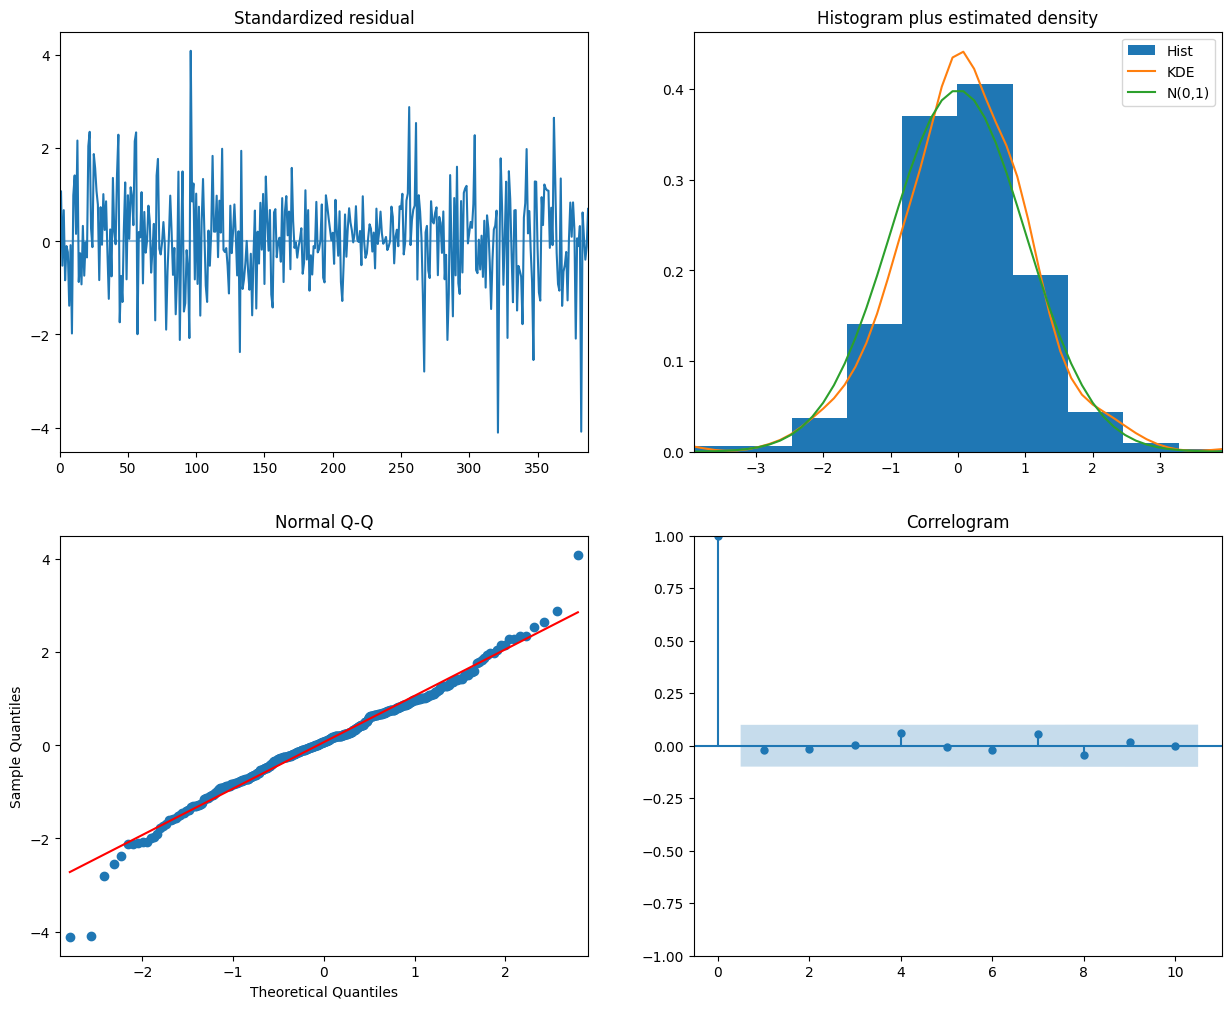

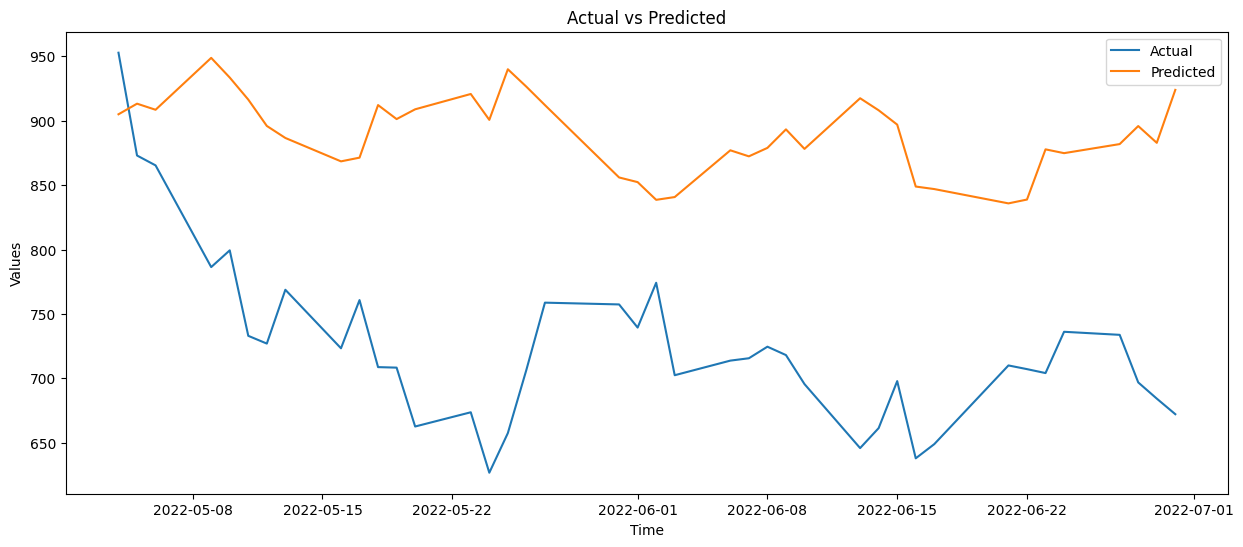

MSE: 31877.15961433986
RMSE: 178.54175874102916
MAE: 167.75117850559278
MAPE: 0.23927949569094023
Training Over Security: META
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-260.392, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-348.194, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-258.525, Time=0.19 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-387.181, Time=0.69 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=6.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-388.923, Time=0.61 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-350.007, Time=0.25 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=4.16 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.47 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-387.173, Time=1.17 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-385.422

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


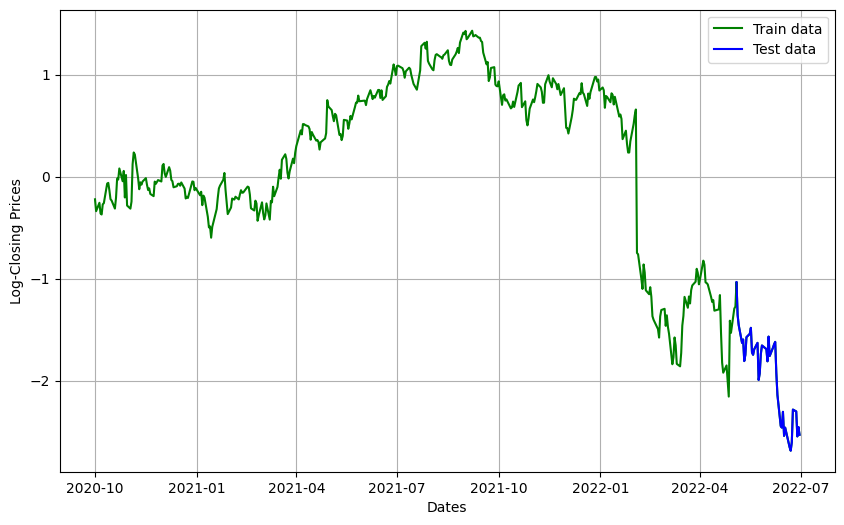

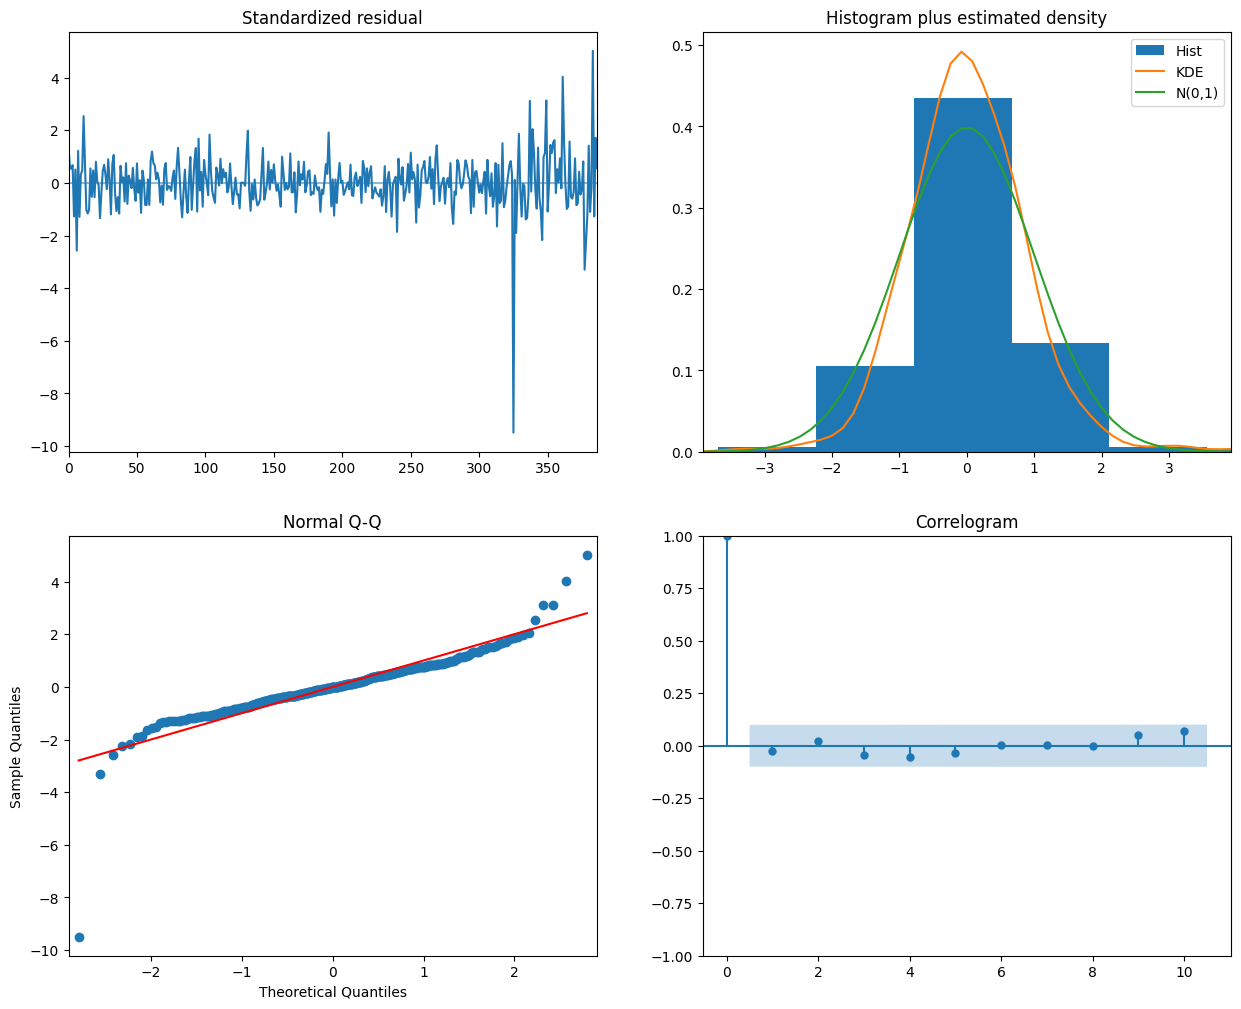

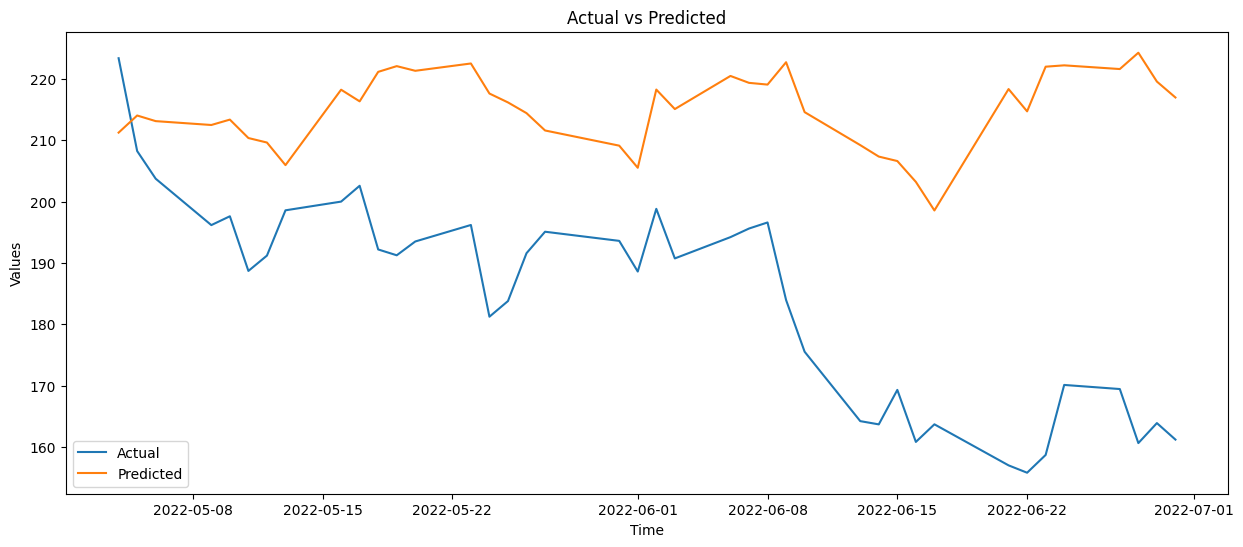

MSE: 1252.974312811392
RMSE: 35.39737720243397
MAE: 31.33033104415805
MAPE: 0.17919024786773696
Training Over Security: MRNA
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-333.474, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-437.087, Time=0.48 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-335.695, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-466.036, Time=1.07 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.57 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.03 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-466.232, Time=0.75 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-437.477, Time=0.61 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=6.11 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.45 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-466.159, Time=2.22 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-465.419, 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


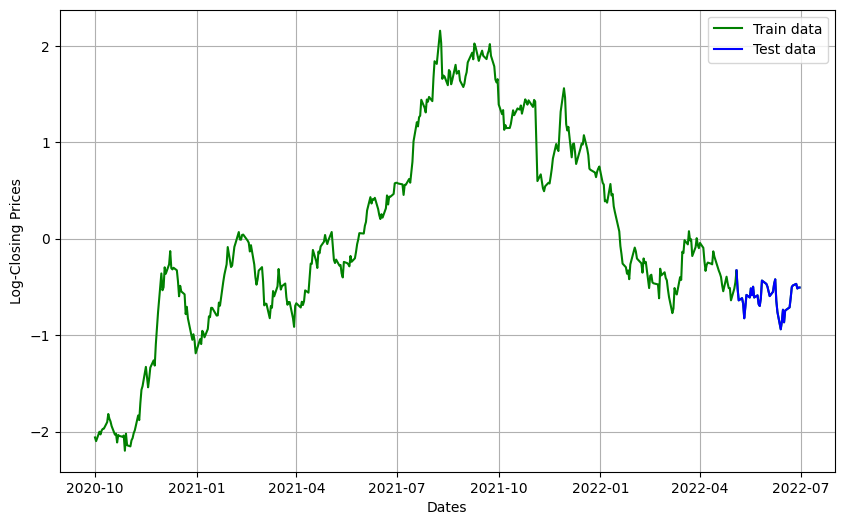

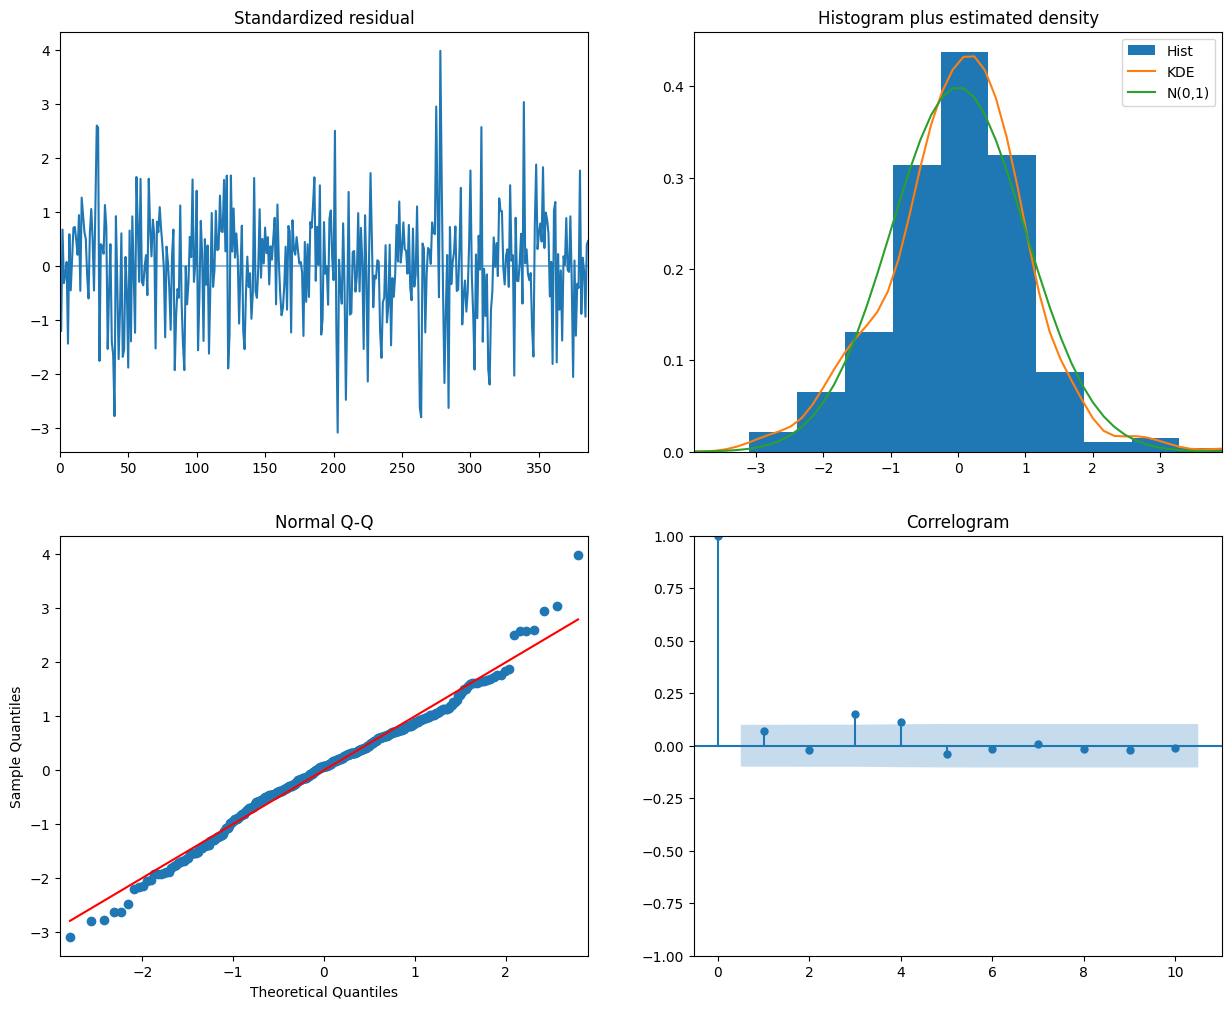

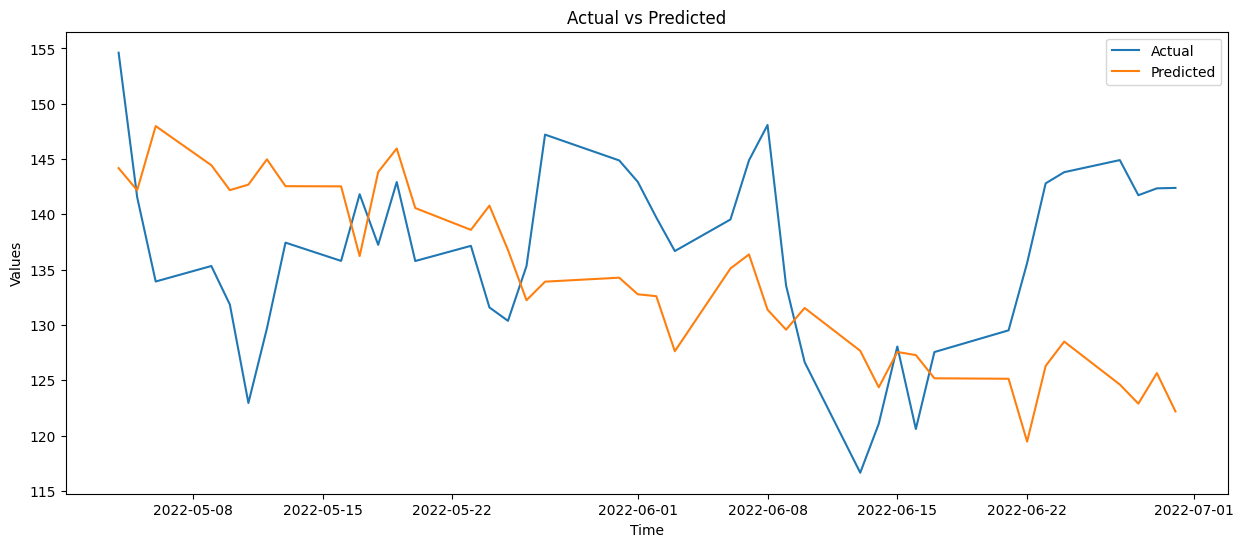

MSE: 119.84271874526942
RMSE: 10.947269922006555
MAE: 9.31291248363337
MAPE: 0.06784721685428068
Training Over Security: BA
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-189.787, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-261.626, Time=0.59 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-189.247, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-301.003, Time=1.78 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.15 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.48 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-302.303, Time=0.75 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-263.028, Time=0.30 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=6.40 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-300.987, Time=1.24 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-299.079, T

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


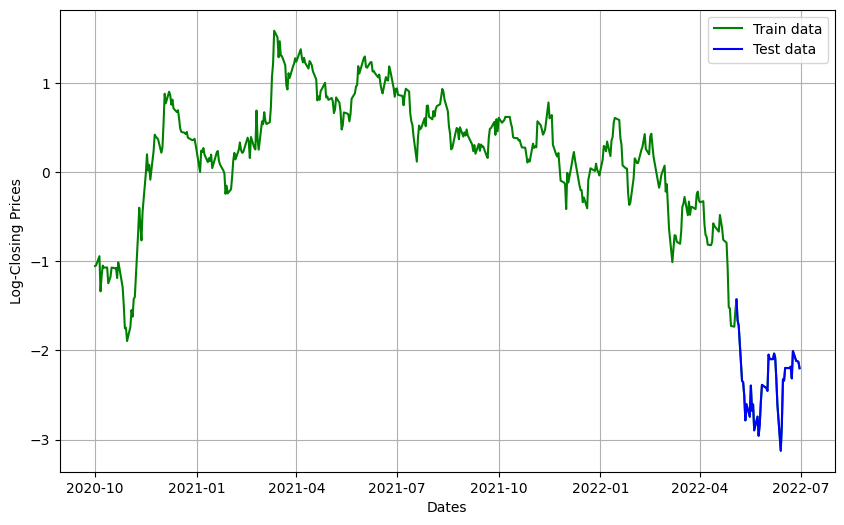

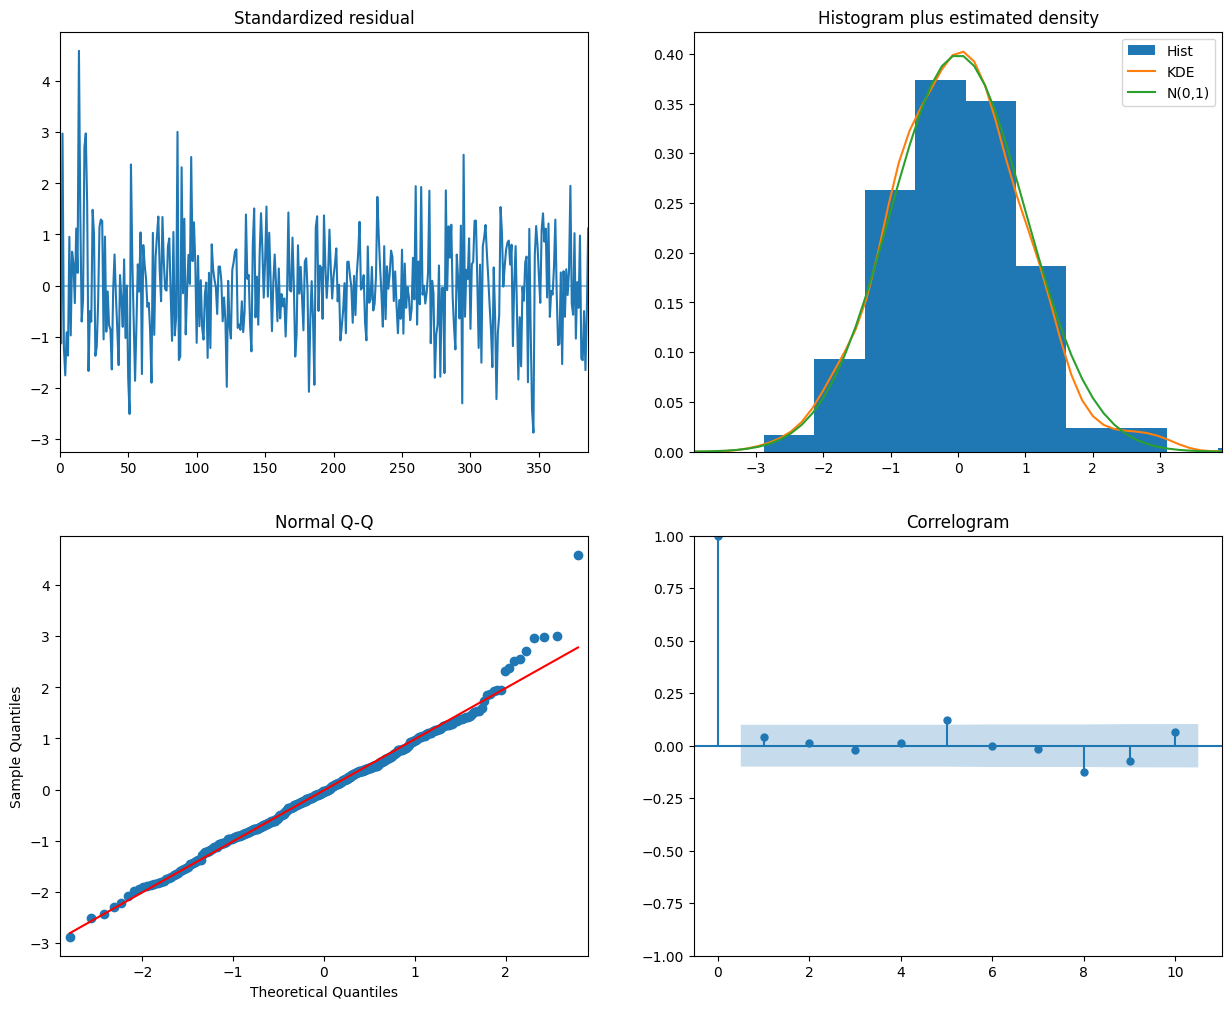

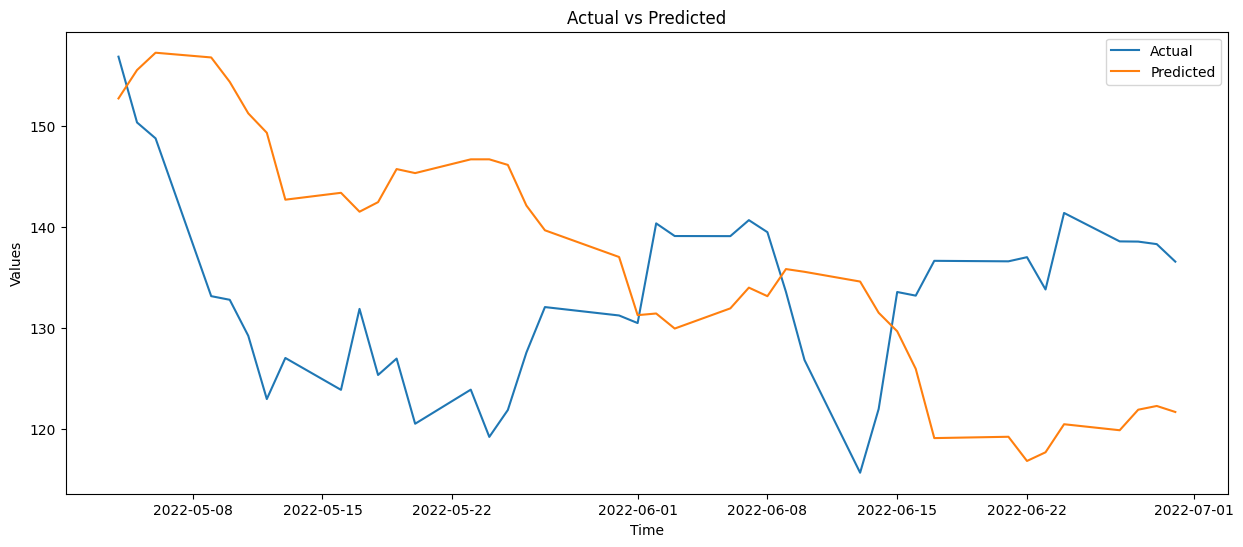

MSE: 253.81134392666272
RMSE: 15.931457683672976
MAE: 14.162897745462908
MAPE: 0.10876744503349052


In [ ]:
for sector, test_security in top_company_by_sector.items():
    print("Training Over Security:", test_security)
    security_data = arima_df[arima_df['Symbol'] == test_security]

    #Split the data
    split_point = int(len(security_data) * 10/ 11)
    train_data = security_data.iloc[:split_point]
    test_data = security_data.iloc[split_point:]

    actual_train = security_data.iloc[:split_point]
    actual_test = security_data.iloc[split_point:]

    actual_train.set_index('Date', inplace=True)
    actual_test.set_index('Date', inplace=True)

    actual_train = actual_train['Log_Close']
    actual_test = actual_test['Log_Close']

    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Log-Closing Prices')
    plt.plot(security_data['Date'], security_data['Log_Close'], color='green', label='Train data')
    plt.plot(test_data['Date'], test_data['Log_Close'], color='blue', label='Test data')
    plt.legend()

    train_data.set_index('Date', inplace=True)
    test_data.set_index('Date', inplace=True)

    y_train = train_data['Log_Close']
    X_train = train_data.drop(['Log_Close', "Symbol", "GICS Sector"], axis=1)

    y_test = test_data['Log_Close']
    X_test = test_data.drop(['Log_Close', "Symbol", "GICS Sector"], axis=1)


    model = auto_arima(y_train, exogenous=X_train,
                        seasonal=True, m=12,
                        start_p=0, start_q=0, max_p=2, max_q=2,
                        start_P=0, start_Q=0, max_P=2, max_Q=2,
                        d=None, D=1,
                        trace=True, error_action='ignore',
                        suppress_warnings=True, stepwise=True)


    predictions = model.predict(n_periods=len(X_test), exogenous=X_test)
    # Result
    print(model.summary())

    model.plot_diagnostics(figsize=(15, 12))
    plt.show()

    predictions = np.array(predictions)
    actual_predictions = reverse_transform(df, test_security, predictions)
    actual_test = reverse_transform(df, test_security, actual_test)
    predictions_series = pd.Series(actual_predictions, index=actual_test.index)

    # Plot the actual vs predicted values
    plt.figure(figsize=(15,6))
    plt.plot(actual_test, label='Actual')
    plt.plot(predictions_series, label='Predicted')
    plt.title('Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()


    # Metrics
    actual = np.array(actual_test)
    predicted = np.array(actual_predictions)

    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual))

    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')

## **THE LSTM MODEL**

In [ ]:
def create_sequential_data(dataset, seq_length, target_variable):
    """
    Create sequential training data from a dataset.

    Parameters:
    - dataset: Pandas DataFrame containing the dataset with columns representing features and target variable.
    - seq_length: Length of the input sequences.

    Returns:
    - X_train: 3D NumPy array of shape (num_samples, seq_length, num_features) containing input features.
    - y_train: 1D NumPy array of shape (num_samples,) containing the target variable.
    """

    num_samples = len(dataset) - seq_length
    num_features = dataset.shape[1]  # Excluding the target variable column
    X_train = np.zeros((num_samples, seq_length, num_features))
    y_train = np.zeros(num_samples)

    for i in range(seq_length, len(dataset)):
      X_train[i - seq_length] = dataset.iloc[i-seq_length:i].values
      y_train[i - seq_length] = dataset.iloc[i, dataset.columns.get_loc(target_variable)]

    return X_train, y_train


In [ ]:
# HYPERPARAMETERS
lstm_df = arima_df.copy()
lstm_df.set_index('Date', inplace=True)
seq_length = 60  # Length of input sequences
num_epochs = 3  # Number of epochs for training
lr = 0.001
optimizer1 = Adam(learning_rate=lr)
optimizer2 = RMSprop(learning_rate=lr)
optimizer3 = SGD(learning_rate=lr)
num_features = 7

loss_fn = 'mean_squared_error'
target_variable = 'Log_Close'
batch_size = 100

print(arima_df.head())

   Log_Close  Log_Volume  Log_News - All News Volume  Log_News - Volume  \
0  -2.119328   -2.124831                    1.221515          -1.321841   
1  -2.209119   -2.167169                   -0.264242          -1.192817   
2  -1.980477   -1.844264                   -0.581714           0.451518   
3  -2.089147   -1.062069                    0.559951          -0.183336   
4  -1.925652   -0.517886                    0.959402          -0.254408   

   Log_News - Analyst Comments  Log_News - Stocks  Log_News - Adverse Events  \
0                    -0.190788          -0.222916                  -0.628987   
1                     0.116723           0.089120                  -0.628987   
2                     0.003230          -0.026043                   1.508056   
3                    -4.057877          -4.146907                   1.615275   
4                     0.003230          -0.026043                   1.508056   

        Date Symbol  GICS Sector  
0 2020-10-01      A  Health Care 

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, num_features)),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),
    Dense(25),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer=optimizer2, loss=loss_fn)

Training Over Sector: Information Technology
Epoch 1/3
321/321 [==============================] - 76s 210ms/step - loss: 1.3316
Epoch 2/3
321/321 [==============================] - 61s 190ms/step - loss: 0.1890
Epoch 3/3
2/2 [==============================] - 1s 24ms/step - loss: 0.0481
Test Symbol: AAPL Test Loss: 0.04811111092567444


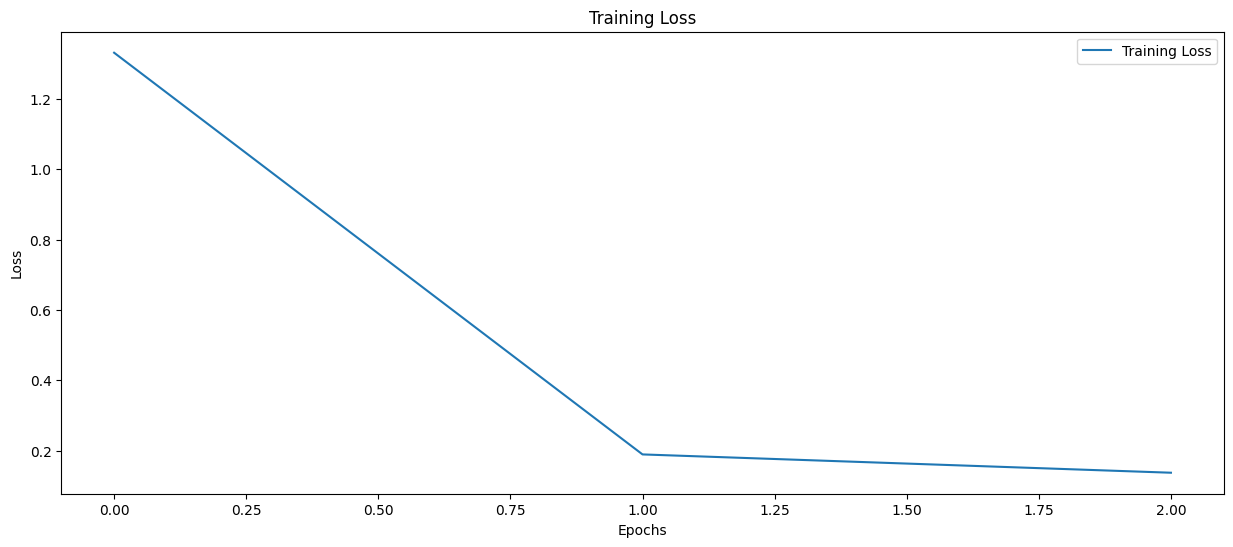

Mean Absolute Error (MAE): 3.296400546234703
Mean Squared Error (MSE): 16.59980175376038
Root Mean Squared Error (RMSE): 4.07428542860713
Mean Absolute Percentage Error (MAPE): 0.061594677713364


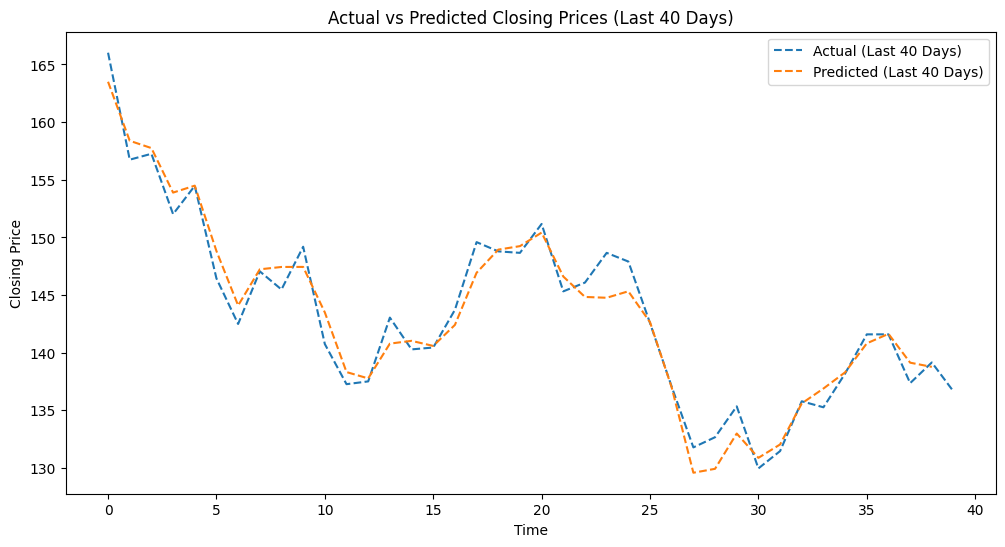

Training Over Sector: Consumer Discretionary
Epoch 1/3
251/251 [==============================] - 47s 187ms/step - loss: 0.1243
Epoch 2/3
251/251 [==============================] - 49s 194ms/step - loss: 0.1207
Epoch 3/3
2/2 [==============================] - 0s 26ms/step - loss: 0.0382
Test Symbol: TSLA Test Loss: 0.038228970021009445


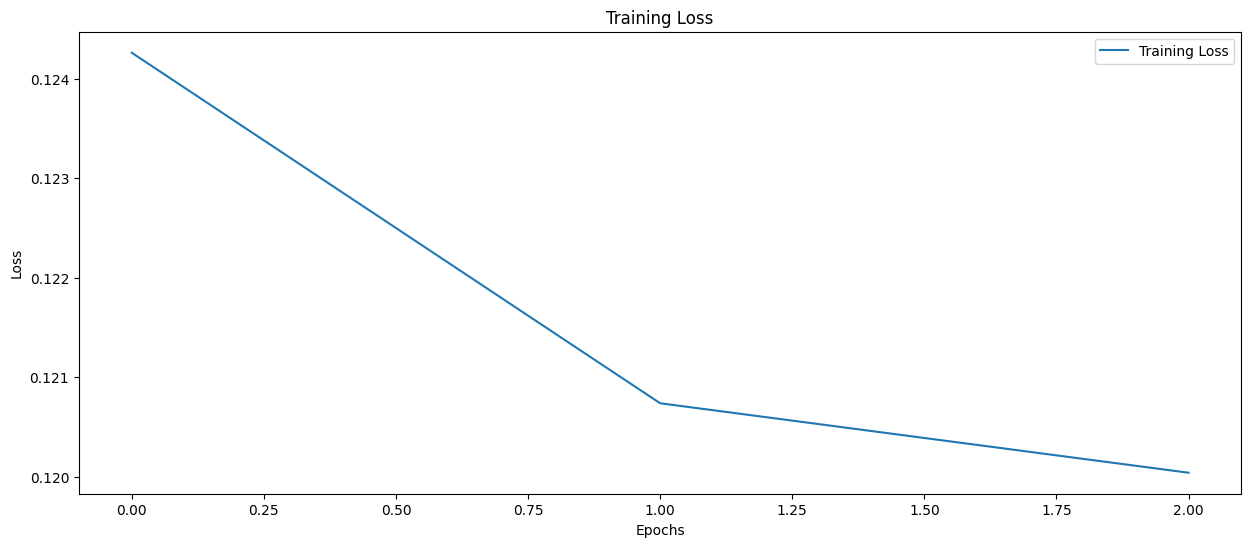

Mean Absolute Error (MAE): 30.19737304171118
Mean Squared Error (MSE): 1326.1900473097883
Root Mean Squared Error (RMSE): 36.416892334599176
Mean Absolute Percentage Error (MAPE): 0.08582022234832247


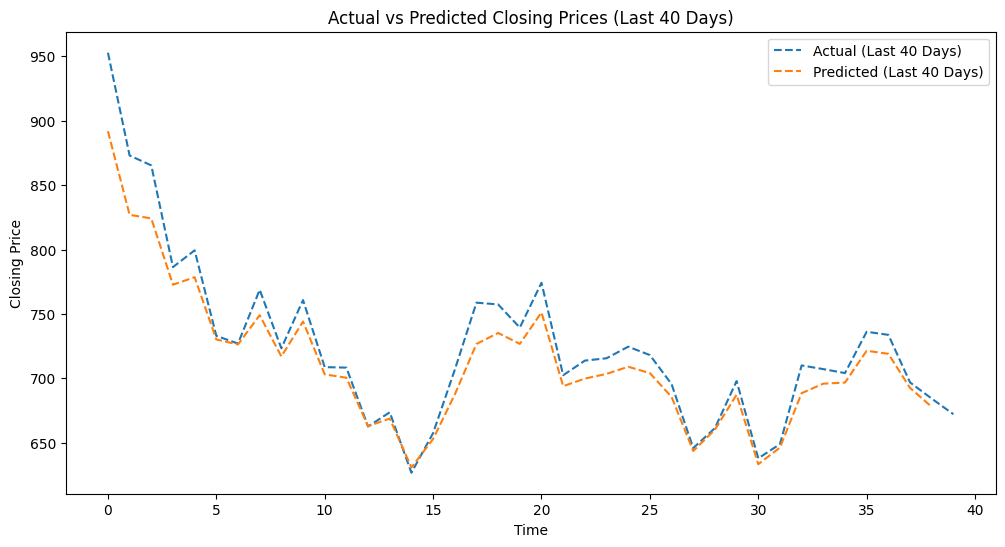

Training Over Sector: Communication Services
Epoch 1/3
105/105 [==============================] - 19s 183ms/step - loss: 0.1241
Epoch 2/3
105/105 [==============================] - 21s 198ms/step - loss: 0.1124
Epoch 3/3
2/2 [==============================] - 0s 66ms/step - loss: 0.0421
Test Symbol: META Test Loss: 0.042078424245119095


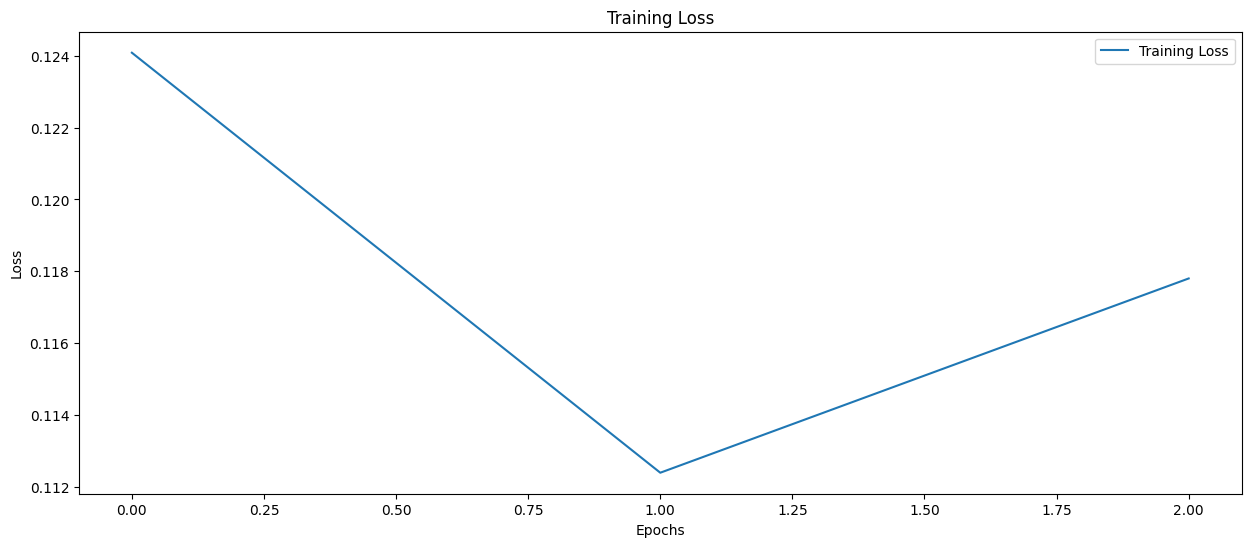

Mean Absolute Error (MAE): 6.740726478146316
Mean Squared Error (MSE): 65.32713722039632
Root Mean Squared Error (RMSE): 8.08252047448049
Mean Absolute Percentage Error (MAPE): 0.09675944953645463


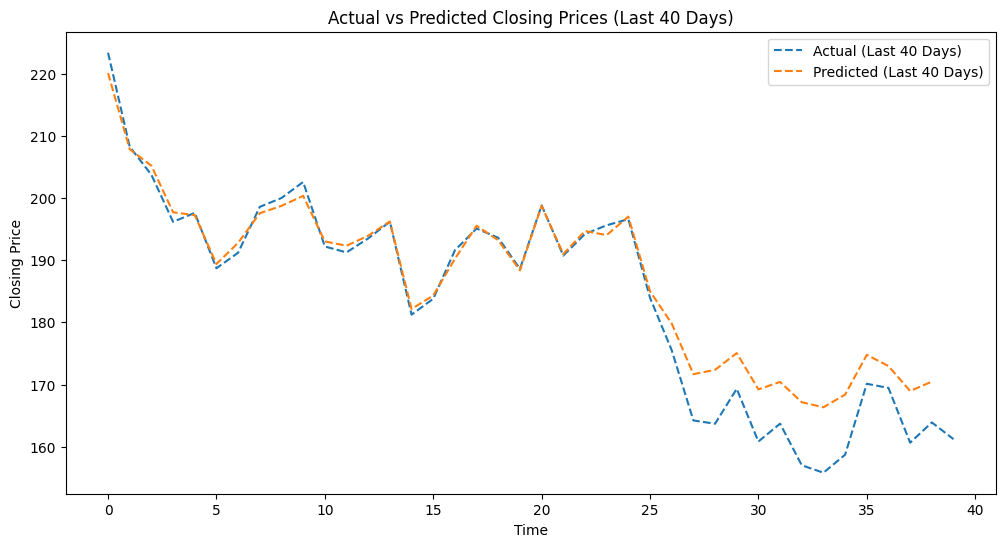

Training Over Sector: Health Care
Epoch 1/3
273/273 [==============================] - 62s 228ms/step - loss: 0.1180
Epoch 2/3
273/273 [==============================] - 51s 186ms/step - loss: 0.1196
Epoch 3/3
2/2 [==============================] - 0s 22ms/step - loss: 0.0406
Test Symbol: MRNA Test Loss: 0.04060498625040054


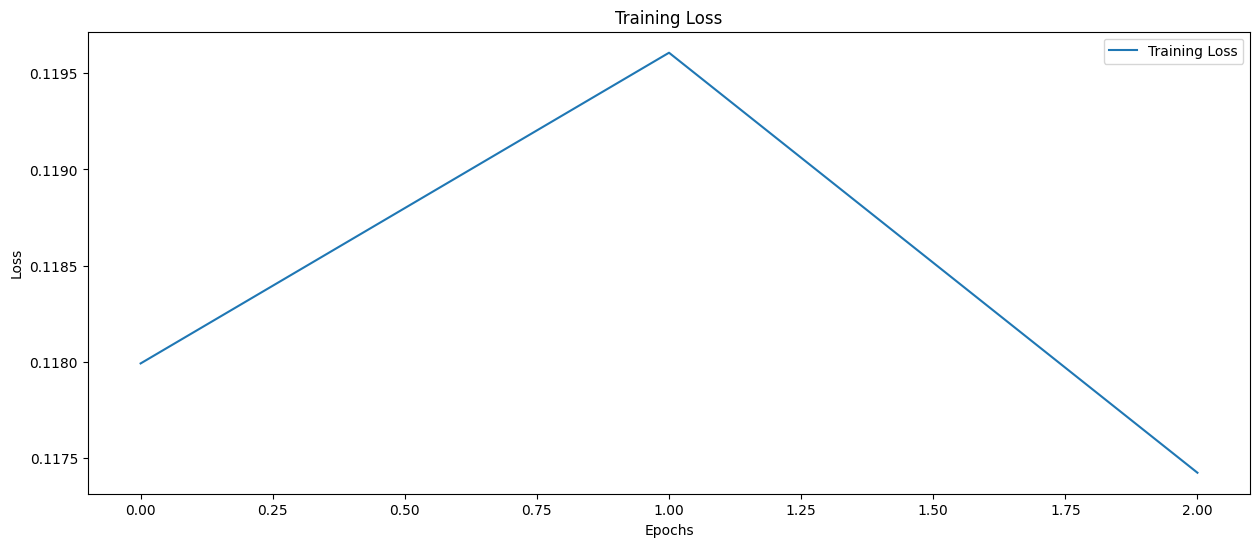

Mean Absolute Error (MAE): 11.367544127269976
Mean Squared Error (MSE): 169.88667415001265
Root Mean Squared Error (RMSE): 13.034058237940041
Mean Absolute Percentage Error (MAPE): 0.09721222770293472


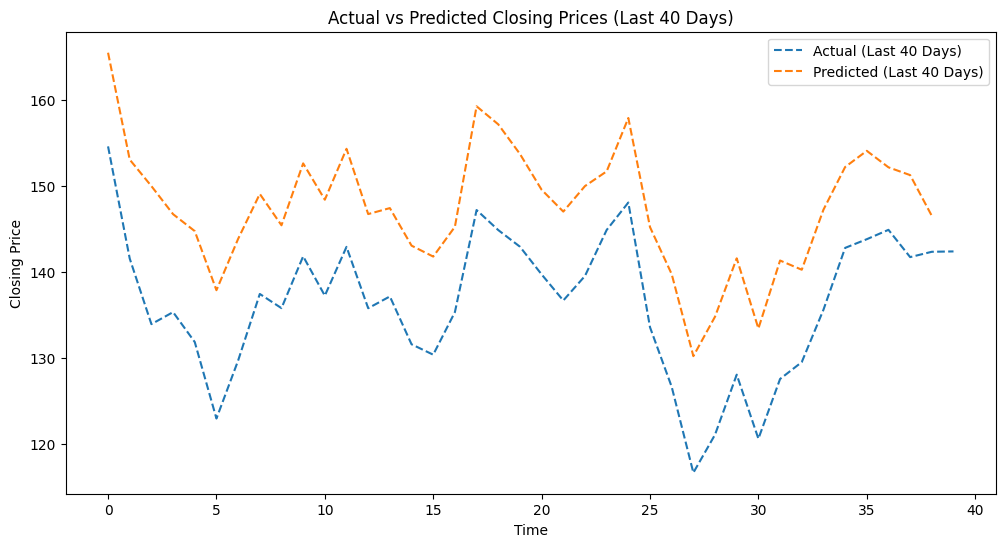

Training Over Sector: Industrials
Epoch 1/3
317/317 [==============================] - 54s 170ms/step - loss: 0.1183
Epoch 2/3
317/317 [==============================] - 54s 171ms/step - loss: 0.1148
Epoch 3/3
2/2 [==============================] - 0s 28ms/step - loss: 0.0814
Test Symbol: BA Test Loss: 0.08138680458068848


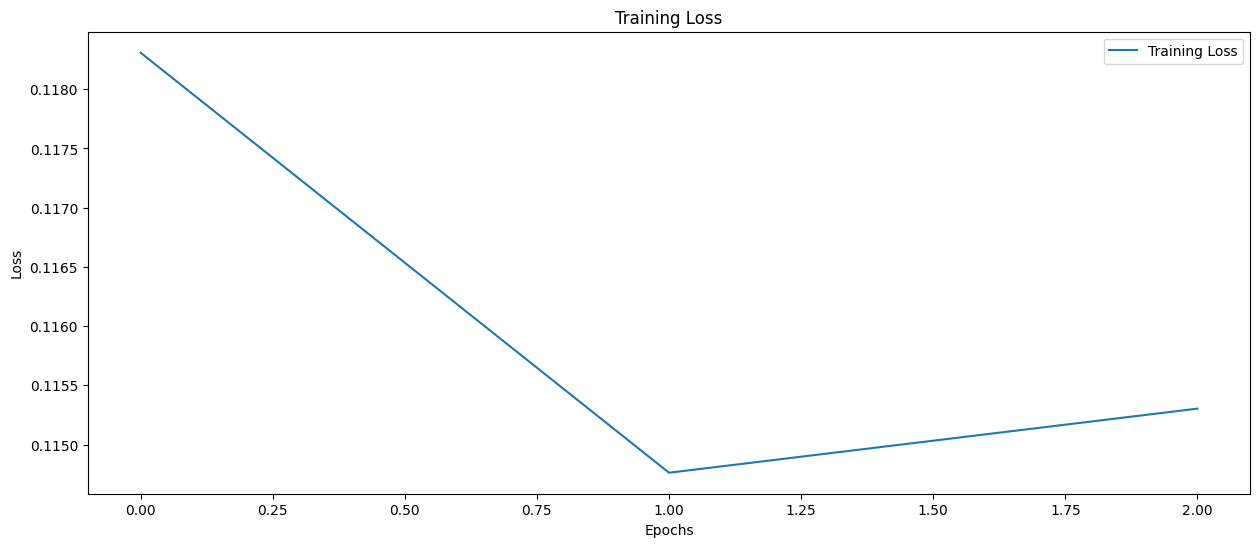

Mean Absolute Error (MAE): 5.36568480461502
Mean Squared Error (MSE): 46.352876139047204
Root Mean Squared Error (RMSE): 6.808294657184514
Mean Absolute Percentage Error (MAPE): 0.07606892060563412


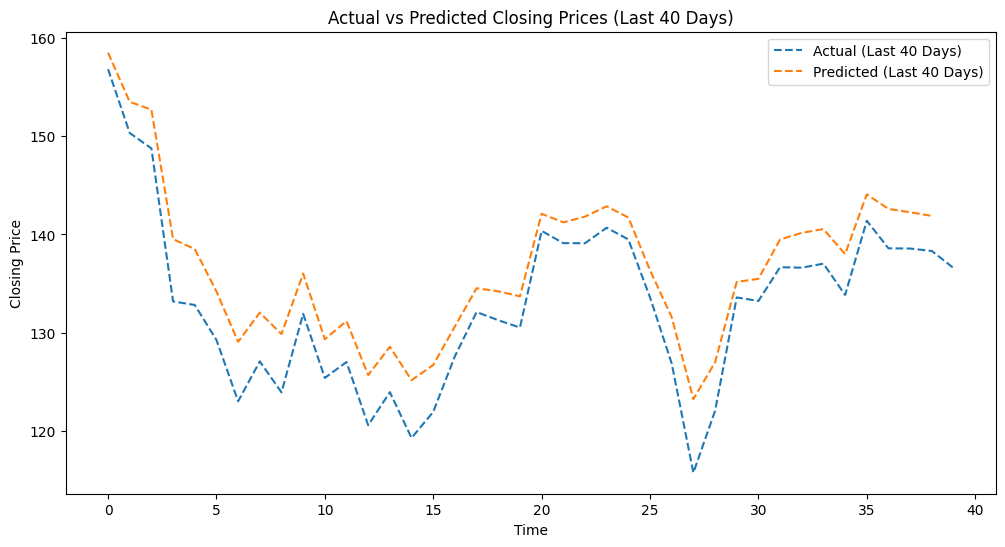

In [ ]:
for sector, test_Symbol in top_company_by_sector.items():
    print("Training Over Sector:", sector)
    industry_df = lstm_df[lstm_df['GICS Sector'] == sector]
    industry_df = industry_df.drop(columns=['GICS Sector'])
    train_df = industry_df[industry_df['Symbol'] != test_Symbol]
    train_df = train_df.drop(columns=['Symbol'])
    # Create X Train and Y Train
    X_train, y_train = create_sequential_data(train_df, seq_length, target_variable)
    # Fit the model through each Symbol
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)

    # Create Test Dataset
    test_df = industry_df[industry_df['Symbol'] == test_Symbol]
    test_df = test_df.drop(columns=['Symbol'])
    X_test_Symbol, y_test_Symbol = create_sequential_data(test_df.iloc[-40 - seq_length:], seq_length, target_variable)
    #Predictions and Test Loss
    predictions = model.predict(X_test_Symbol)
    test_loss = model.evaluate(X_test_Symbol, y_test_Symbol)
    print("Test Symbol:", test_Symbol, 'Test Loss:', test_loss)
    #Reverse Transformations and Shifting of Predictions
    predictions = reverse_transform(df, test_Symbol, predictions)
    shifted_predictions = np.roll(predictions, -1)
    shifted_predictions = shifted_predictions[:-1]
    y_test_Symbol = reverse_transform(df, test_Symbol, y_test_Symbol)

    train_loss = history.history['loss']

    # Plot training and test loss
    plt.figure(figsize=(15, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Calculate additional error metrics
    mae = mean_absolute_error(y_test_Symbol, predictions)
    mse = mean_squared_error(y_test_Symbol, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_Symbol - predictions) / y_test_Symbol))

    print('Mean Absolute Error (MAE):', mae)
    print('Mean Squared Error (MSE):', mse)
    print('Root Mean Squared Error (RMSE):', rmse)
    print('Mean Absolute Percentage Error (MAPE):', mape)

    # Plot the entire time series of the Symbol along with the actual and predicted values for the last 40 days
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test_Symbol)), y_test_Symbol, label='Actual (Last 40 Days)', linestyle='--')
    plt.plot(np.arange(len(shifted_predictions)), shifted_predictions, label='Predicted (Last 40 Days)', linestyle='--')
    plt.title('Actual vs Predicted Closing Prices (Last 40 Days)')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()


## **GRU MODEL**

In [ ]:
# HYPERPARAMETERS
gru_df = arima_df.copy()
gru_df.set_index('Date', inplace=True)
seq_length = 60  # Length of input sequences
num_epochs = 3  # Number of epochs for training
lr = 0.001
optimizer1 = Adam(learning_rate=lr)
optimizer2 = RMSprop(learning_rate=lr)
optimizer3 = SGD(learning_rate=lr)
num_features = 7

loss_fn = 'mean_squared_error'
target_variable = 'Log_Close'
batch_size = 100

In [ ]:
# Build the GRU model
model2 = Sequential([
    GRU(50, return_sequences=True, input_shape=(seq_length, num_features)),
    BatchNormalization(),
    Dropout(0.2),
    GRU(50, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),
    Dense(25),
    Dropout(0.5),
    Dense(1)
])

model2.compile(optimizer=optimizer2, loss=loss_fn)

Training Over Sector: Information Technology
Epoch 1/3
321/321 [==============================] - 58s 162ms/step - loss: 1.7024
Epoch 2/3
321/321 [==============================] - 51s 158ms/step - loss: 0.1880
Epoch 3/3
2/2 [==============================] - 1s 22ms/step - loss: 0.0447
Test Symbol: AAPL Test Loss: 0.04471128061413765


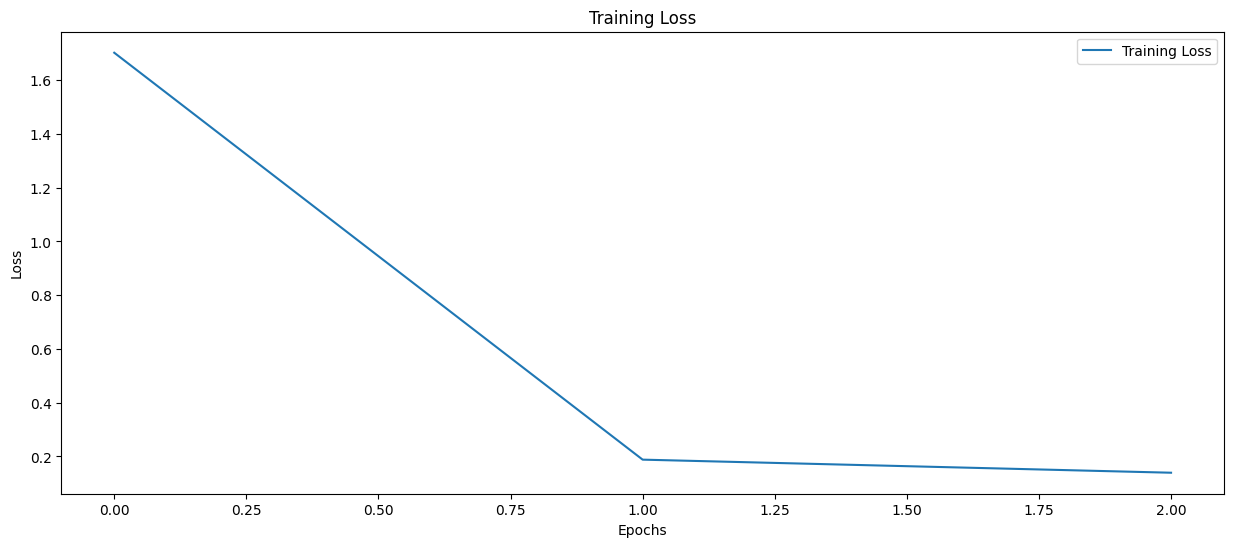

Mean Absolute Error (MAE): 3.0795447794395514
Mean Squared Error (MSE): 15.307600916759872
Root Mean Squared Error (RMSE): 3.9124929286530183
Mean Absolute Percentage Error (MAPE): 0.05960076770989284


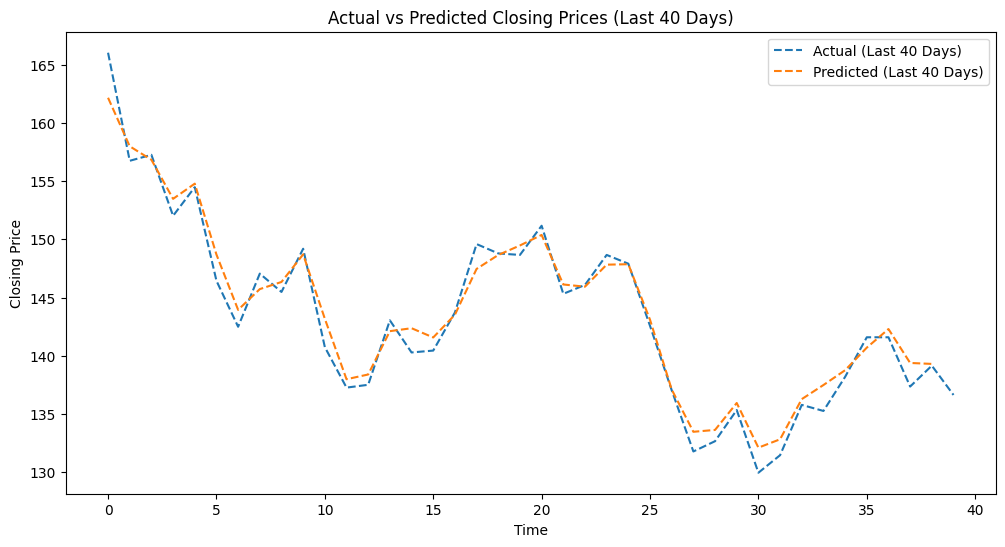

Training Over Sector: Consumer Discretionary
Epoch 1/3
251/251 [==============================] - 40s 160ms/step - loss: 0.1284
Epoch 2/3
251/251 [==============================] - 53s 213ms/step - loss: 0.1261
Epoch 3/3
2/2 [==============================] - 0s 32ms/step - loss: 0.0425
Test Symbol: TSLA Test Loss: 0.04247421771287918


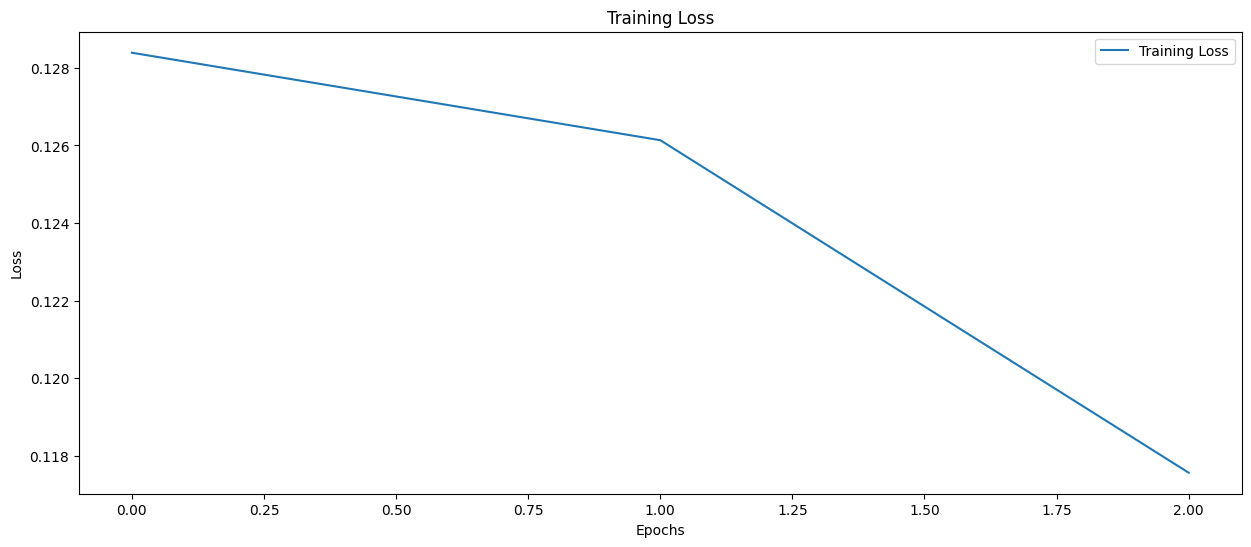

Mean Absolute Error (MAE): 31.48987194013222
Mean Squared Error (MSE): 1436.6932076097141
Root Mean Squared Error (RMSE): 37.903736064004484
Mean Absolute Percentage Error (MAPE): 0.09495807617068501


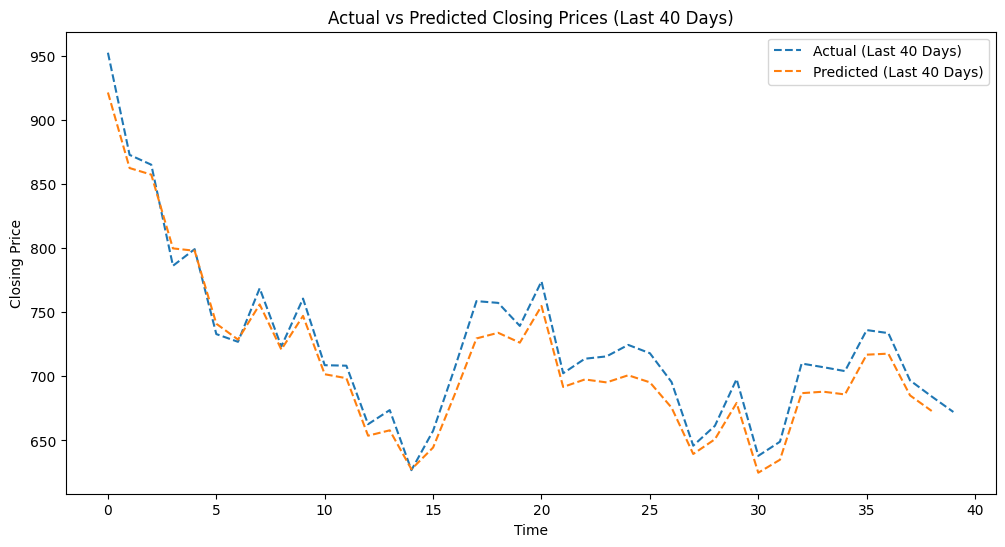

Training Over Sector: Communication Services
Epoch 1/3
105/105 [==============================] - 17s 159ms/step - loss: 0.1216
Epoch 2/3
105/105 [==============================] - 17s 159ms/step - loss: 0.1148
Epoch 3/3
2/2 [==============================] - 0s 25ms/step - loss: 0.1227
Test Symbol: META Test Loss: 0.12270945310592651


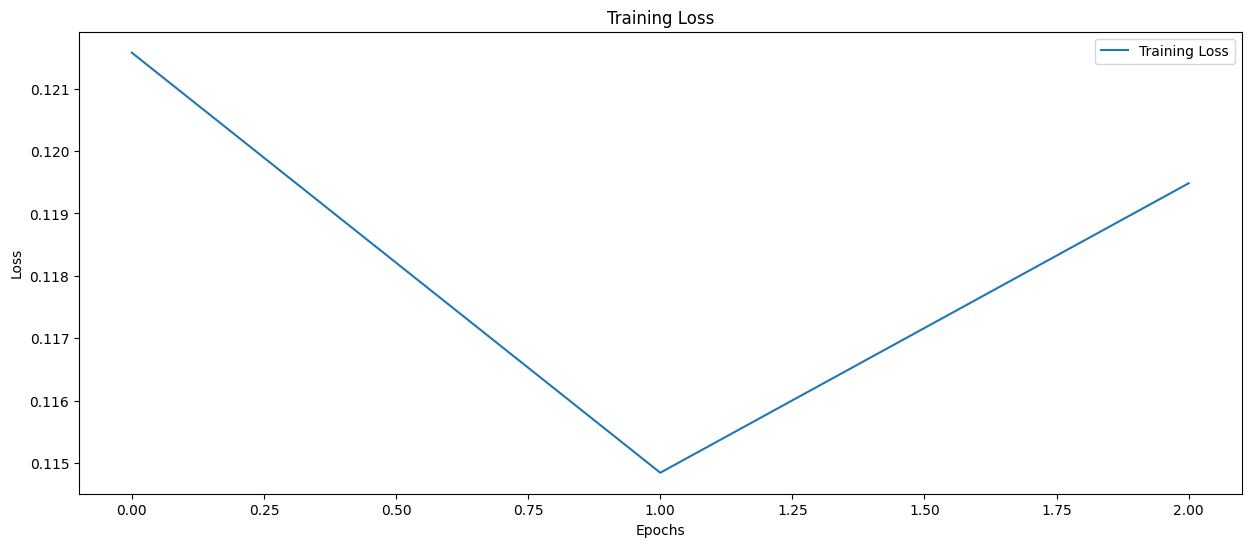

Mean Absolute Error (MAE): 12.695481749303337
Mean Squared Error (MSE): 201.21057760422764
Root Mean Squared Error (RMSE): 14.184871434180419
Mean Absolute Percentage Error (MAPE): 0.11889096258643943


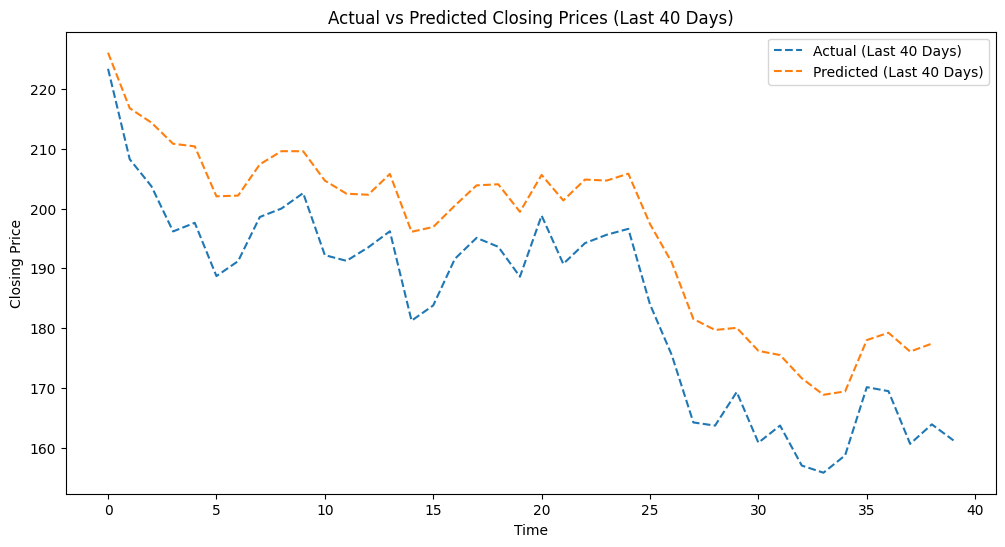

Training Over Sector: Health Care
Epoch 1/3
273/273 [==============================] - 44s 162ms/step - loss: 0.1211
Epoch 2/3
273/273 [==============================] - 49s 179ms/step - loss: 0.1204
Epoch 3/3
2/2 [==============================] - 0s 23ms/step - loss: 0.0576
Test Symbol: MRNA Test Loss: 0.057582467794418335


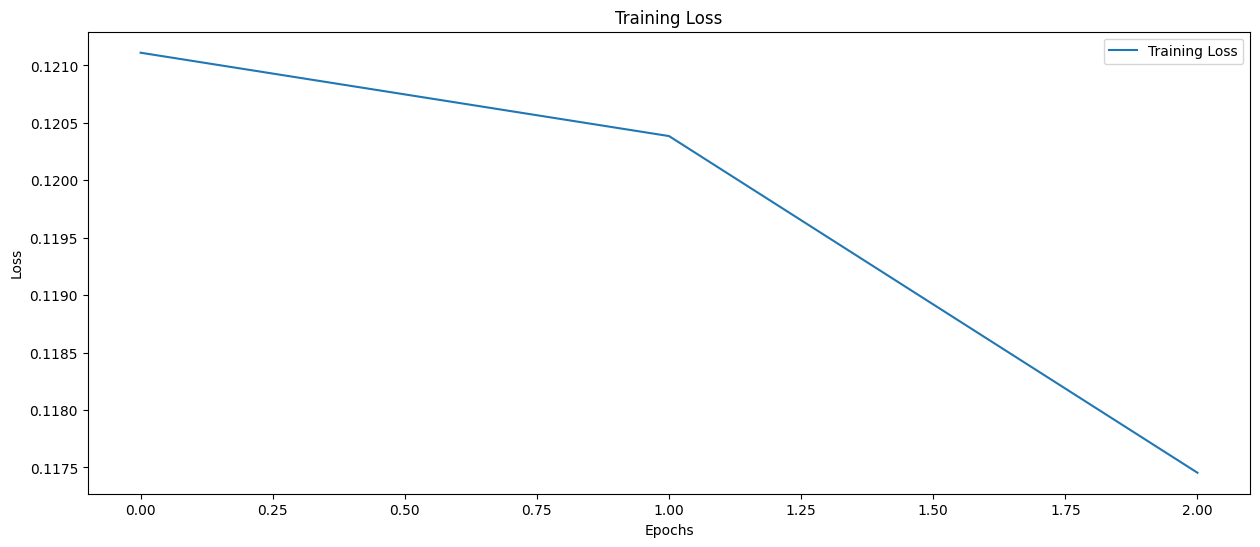

Mean Absolute Error (MAE): 14.281839840523867
Mean Squared Error (MSE): 245.10180294328302
Root Mean Squared Error (RMSE): 15.65572748048723
Mean Absolute Percentage Error (MAPE): 0.11407051550652934


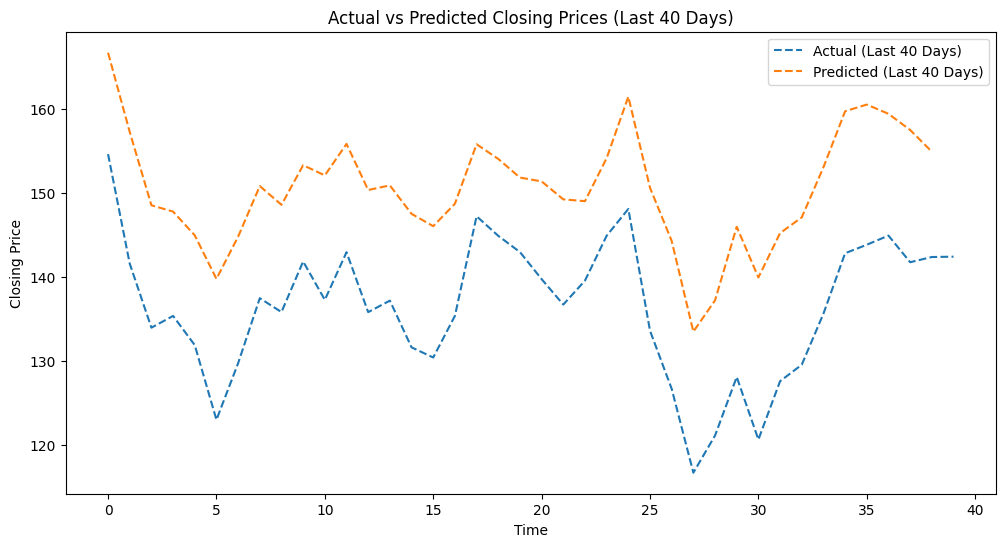

Training Over Sector: Industrials
Epoch 1/3
317/317 [==============================] - 55s 174ms/step - loss: 0.1125
Epoch 2/3
317/317 [==============================] - 53s 167ms/step - loss: 0.1141
Epoch 3/3
2/2 [==============================] - 0s 28ms/step - loss: 0.2646
Test Symbol: BA Test Loss: 0.26457080245018005


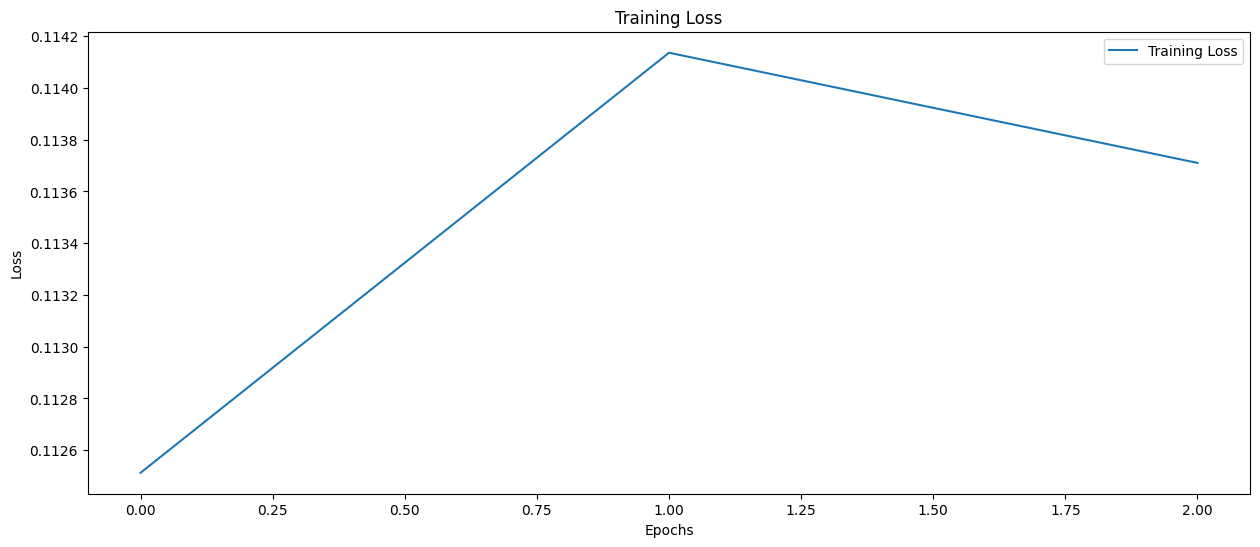

Mean Absolute Error (MAE): 10.910987547751875
Mean Squared Error (MSE): 154.81345979506187
Root Mean Squared Error (RMSE): 12.442405707702264
Mean Absolute Percentage Error (MAPE): 0.09703197291300442


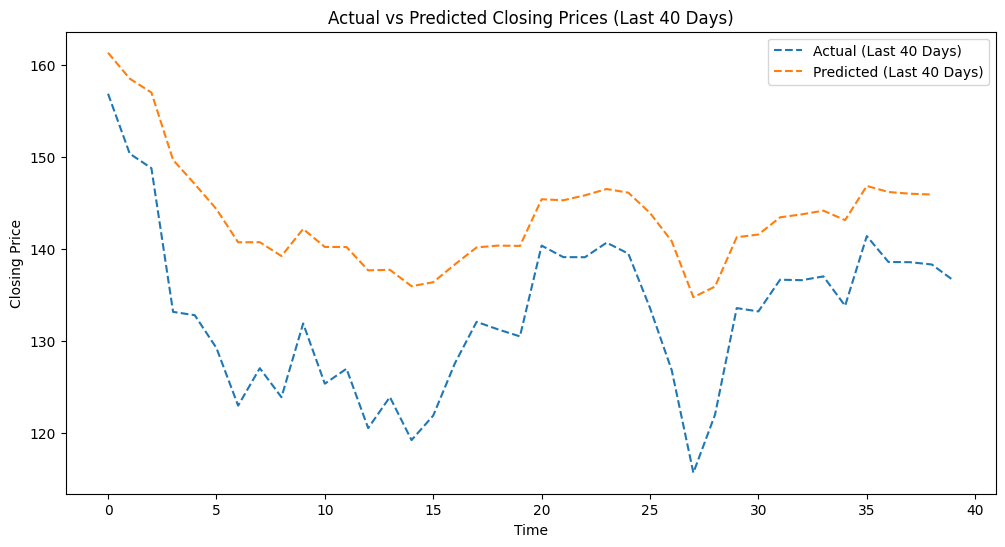

In [ ]:
for sector, test_Symbol in top_company_by_sector.items():
    print("Training Over Sector:", sector)
    industry_df = lstm_df[lstm_df['GICS Sector'] == sector]
    industry_df = industry_df.drop(columns=['GICS Sector'])
    train_df = industry_df[industry_df['Symbol'] != test_Symbol]
    train_df = train_df.drop(columns=['Symbol'])
    # Create X Train and Y Train
    X_train, y_train = create_sequential_data(train_df, seq_length, target_variable)
    # Fit the model through each Symbol
    history = model2.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size)

    # Create Test Dataset
    test_df = industry_df[industry_df['Symbol'] == test_Symbol]
    test_df = test_df.drop(columns=['Symbol'])
    X_test_Symbol, y_test_Symbol = create_sequential_data(test_df.iloc[-40 - seq_length:], seq_length, target_variable)
    #Predictions and Test Loss
    predictions = model2.predict(X_test_Symbol)
    test_loss = model2.evaluate(X_test_Symbol, y_test_Symbol)
    print("Test Symbol:", test_Symbol, 'Test Loss:', test_loss)
    #Reverse Transformations and Shifting of Predictions
    predictions = reverse_transform(df, test_Symbol, predictions)
    shifted_predictions = np.roll(predictions, -1)
    shifted_predictions = shifted_predictions[:-1]
    y_test_Symbol = reverse_transform(df, test_Symbol, y_test_Symbol)

    train_loss = history.history['loss']

    # Plot training and test loss
    plt.figure(figsize=(15, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Calculate additional error metrics
    mae = mean_absolute_error(y_test_Symbol, predictions)
    mse = mean_squared_error(y_test_Symbol, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_Symbol - predictions) / y_test_Symbol))

    print('Mean Absolute Error (MAE):', mae)
    print('Mean Squared Error (MSE):', mse)
    print('Root Mean Squared Error (RMSE):', rmse)
    print('Mean Absolute Percentage Error (MAPE):', mape)


    # Plot the entire time series of the Symbol along with the actual and predicted values for the last 40 days
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test_Symbol)), y_test_Symbol, label='Actual (Last 40 Days)', linestyle='--')
    plt.plot(np.arange(len(shifted_predictions)), shifted_predictions, label='Predicted (Last 40 Days)', linestyle='--')
    plt.title('Actual vs Predicted Closing Prices (Last 40 Days)')
    plt.xlabel('Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
